# Importing necessary packages and first glance on data

In [1]:
# for getting actual exchange rate
!pip install yfinance

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from sklearn.impute import SimpleImputer

import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [4]:
# this one of the first dataframe option
df = pd.read_csv('/content/drive/MyDrive/fixed_lun_real_estate_april.csv')
df.head(2)

price currency  city_id      main_area second_area         street_name  \
0  3500.0        ₴      1.0  Немишлянський    626 м.р.  Велозаводська вул.   
1  4500.0        ₴      1.0      Київський  Барабашово     Барабашова вул.   

   subway  total_square  kitchen_square  living_square  ...  photo_counts  \
0   False          70.0             9.0           50.0  ...            21   
1    True          33.0             5.0           20.0  ...            10   

                                         description   latitude  longitude  \
0  Відмінна пропозиція! Салтівка! Здається просто...  49.982861  36.356247   
1  Здається 1 кімнатна квартира на 9-му поверсі 9...  50.005375  36.298725   

   agency_name scraped_date  date_publication  \
0          КИТ   2025-04-03               NaN   
1          КИТ   2025-04-03               NaN   

                                                 url is_active  \
0  https://rieltor.ua/harkov/flats-rent/view/1179...      True   
1  https://rieltor.ua/harkov/flats-rent/view/1179...      True   

   date_when_no_active  
0                  NaN  
1                  NaN  

[2 rows x 27 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39418 entries, 0 to 39417
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                39418 non-null  float64
 1   currency             39418 non-null  object 
 2   city_id              37639 non-null  float64
 3   main_area            32471 non-null  object 
 4   second_area          33814 non-null  object 
 5   street_name          39418 non-null  object 
 6   subway               39418 non-null  bool   
 7   total_square         39418 non-null  float64
 8   kitchen_square       39418 non-null  float64
 9   living_square        39418 non-null  float64
 10  rooms                39358 non-null  float64
 11  total_floors         39418 non-null  int64  
 12  flat_floor           39418 non-null  int64  
 13  deal_type            39418 non-null  object 
 14  checked_apartment    39418 non-null  bool   
 15  newbuild_name        14696 non-null 

We can see a lot of empty values in different columns of the data. What's even more striking is that the city_name column has missing entries. Since I scraped the data by specific cities, let's try to figure out what happened here.

# Dealing with data preprocessing for EDA

In [6]:
# let's find out top 10 settlement from url with empty city_id
test_df = df[df['city_id'].isna()]
names_area = []

for row in test_df.itertuples():
  url = row.url
  url = url.replace('https://rieltor.ua/', '')
  url = url.split('/')[0]
  names_area.append(url)

t = pd.DataFrame({'city': names_area})
t['city'].value_counts().reset_index().head(10)

city  count
0       sofievskaja-borschagovka    422
1                      sokolniki    226
2                brjuhovichi-917     99
3                   vishnevoe-67     84
4  petropavlovskaja-borschagovka     81
5                 petrovskoe-676     72
6                  krjukovschina     70
7                  novoselki-599     68
8                    vinniki-357     67
9                      vyshgorod     62

It's clear that none of these are exact cities; they're settlements located near a city from the list. To be honest, this isn't my main focus right now, but in a future version of this project, we could investigate how the (rent/sale) price of these settlement's flats correlates with the main city's flats.

In [7]:
# remove empty column or column with high percent of missing values or columns in which we are not interesting in.
df.drop(columns=['scraped_date', 'date_publication', 'url', 'is_active', 'date_when_no_active'], inplace=True)
df.dropna(subset='city_id', inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
# decode city codes
city_code = {"Харків": 1, "Київ": 2, "Львів": 3, "Дніпро": 4, "Одеса": 5, "Кропивницький": 6,
             "Полтава": 7, "Івано-Франківськ": 8, "Вінниця": 9, "Луцьк": 10, "Ужгород": 11,
             "Рівне": 12, "Чернігів": 13, "Тернопіль": 14, "Чернівці": 15, "Житомир": 16,
             "Хмельницький": 17, "Черкаси": 18, "Миколаїв": 19, "Запоріжжя": 20, "Суми": 21,
             "Кривий Ріг": 22,}

reverse_city_code = {v:k for k, v in city_code.items()}
df['city_id'] = df['city_id'].apply(lambda x: reverse_city_code.get(x))
df.rename(columns={'city_id':'city_name'}, inplace=True)

Convert price into one currency I'll pick national currency hryvnia.

In [9]:
usd_uah = np.round(yf.Ticker("USDUAH=X").history(period="1d")["Close"].iloc[-1], 4)
eur_uah = np.round(yf.Ticker("EURUAH=X").history(period="1d")["Close"].iloc[-1], 4)

print("Today's exchange rates")
print(f"1 USD = {usd_uah} UAH")
print(f"1 EUR = {eur_uah} UAH")

Today's exchange rates
1 USD = 41.6707 UAH
1 EUR = 47.4799 UAH


In [10]:
def convert_into_uah(price, currency, usd_to_uah=usd_uah, eur_to_uah=eur_uah):
  if currency == "$":
    return np.round(price * usd_to_uah, 2)
  elif currency == "€":
    return np.round(price * eur_to_uah, 2)
  else:
    return price

In [11]:
converted_prices = []

for row in df.itertuples():
  converted_price = convert_into_uah(row.price, row.currency)
  converted_prices.append(converted_price)

df['price_uah'] = converted_prices

In [12]:
df.drop(columns=['price'], inplace=True)

Before dive deep into EDA and further building machine learning model, let's make some research of outliers.

# Dealing with outliers

In [13]:
# before we start dealing with outliers, we need to remove any duplicates from the data
df.duplicated().sum()

np.int64(73)

In [14]:
df.drop_duplicates(inplace=True)

The simplest way to see outliers use describe

In [15]:
df.describe()

total_square  kitchen_square  living_square         rooms  \
count   37566.000000    37566.000000   37566.000000  37506.000000   
mean       76.016622       13.814677      35.256690      2.005252   
std       991.282376        8.686881      23.062823      0.949659   
min        10.000000        1.000000       1.000000      1.000000   
25%        43.500000        8.000000      20.000000      1.000000   
50%        56.000000       12.000000      30.000000      2.000000   
75%        74.000000       17.000000      42.700000      3.000000   
max    138000.000000      130.000000     500.000000      6.000000   

       total_floors    flat_floor  photo_counts      latitude     longitude  \
count  37566.000000  37566.000000  37566.000000  37415.000000  37415.000000   
mean      11.725843      6.948145     14.154981     49.191492     30.147190   
std        7.157745      5.452785      8.360501      1.429881      3.847242   
min        1.000000      1.000000      1.000000     46.349777     22.243141   
25%        6.000000      3.000000      9.000000     48.451645     27.003065   
50%       10.000000      5.000000     12.000000     49.820492     30.590498   
75%       16.000000      9.000000     18.000000     50.411140     32.040707   
max       47.000000     36.000000    200.000000     51.543407     36.443951   

          price_uah  
count  3.756600e+04  
mean   2.874869e+06  
std    5.754192e+06  
min    1.000000e+03  
25%    5.417191e+05  
50%    1.875182e+06  
75%    3.333656e+06  
max    3.285232e+08

It's clear there are outliers in our data, especially with the different square footage measurements. The photo_counts column might have some too. When it comes to price_uah (last column), it's hard to say what's an outlier because we don't know if it's a sale price (which can be high) or a rental price (which is usually much lower).

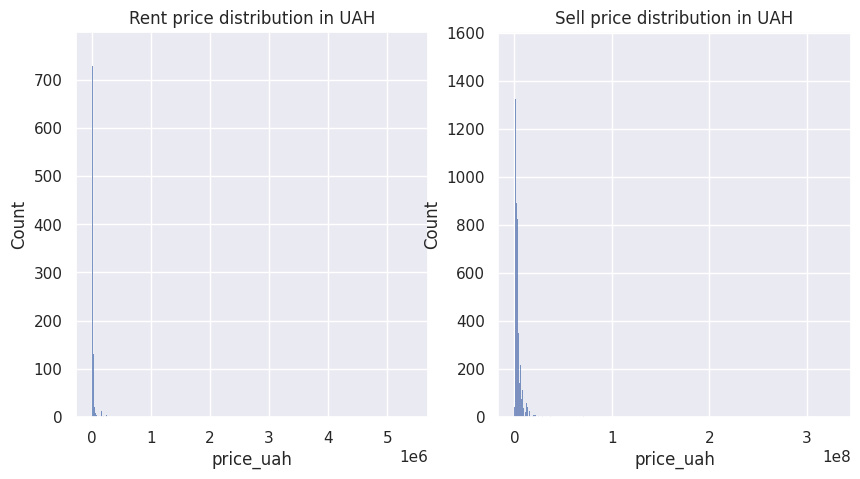

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(data=df[(df['deal_type'] == 'Rent')], x='price_uah', ax=ax[0])
ax[0].set_title("Rent price distribution in UAH")

sns.histplot(data=df[(df['deal_type'] == 'Sale')], x='price_uah', ax=ax[1])
ax[1].set_title("Sell price distribution in UAH")

plt.show()

See that both deal type have outliers, let's remove them by simple interquartile range approach.

In [17]:
def remove_outliers(dataframe, column, iqr_multiplier=1.5):
  q1 = dataframe[column].quantile(0.25)
  q3 = dataframe[column].quantile(0.75)
  iqr = q3-q1

  upper_limit = q3 + (iqr_multiplier*iqr)
  lower_limit = q1 - (iqr_multiplier*iqr)
  return upper_limit, lower_limit

In [18]:
upper_limit, lower_limit = remove_outliers(df, 'total_square')
df = df[(df['total_square'] > lower_limit) & (df['total_square'] < upper_limit)]

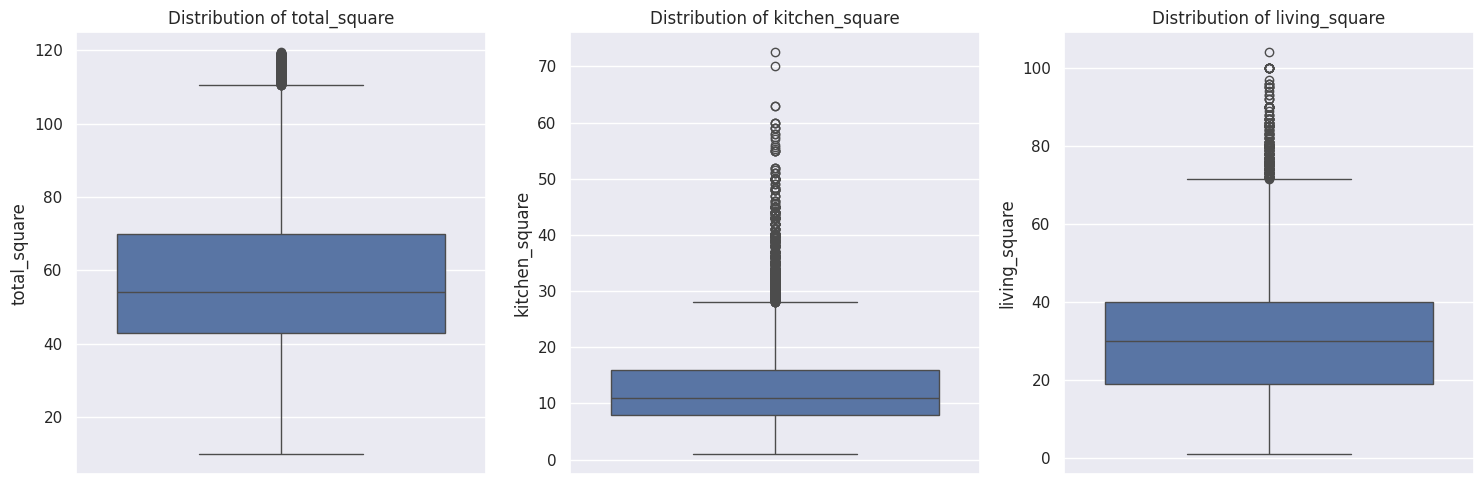

In [19]:
area_col_name = ['total_square', 'kitchen_square', 'living_square']

f, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(area_col_name):
  sns.boxplot(y=df[col], ax=ax[i])
  ax[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

There are still some outliers, but they're not as bad as they were, so it's okay. Next, we need to remove outliers from the price column. We could do this in two ways: either use the IQR method to just delete all the big outliers (which is the easy way out) or remove big outliers separately for each specific city. I think the second way might make the data seem too artificial, which probably isn't good.

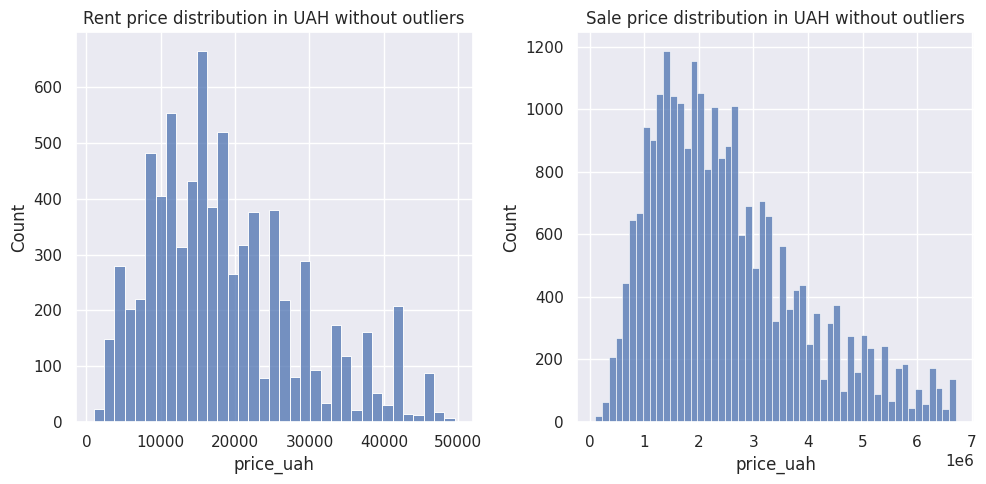

In [20]:
rent_dataframe = df[(df['deal_type'] == 'Rent')]
sale_dataframe = df[(df['deal_type'] == 'Sale')]

# also i increase here iqr multiplier
upper_limit_r, lower_limit_r = remove_outliers(rent_dataframe, 'price_uah', 1.5)
upper_limit_s, lower_limit_s = remove_outliers(sale_dataframe, 'price_uah', 1.5)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

rent_df_no = rent_dataframe[(rent_dataframe['price_uah'] < upper_limit_r) \
                        & (rent_dataframe['price_uah'] > lower_limit_r)]
sale_df_no = sale_dataframe[(sale_dataframe['price_uah'] < upper_limit_s) \
                                 & (sale_dataframe['price_uah'] > lower_limit_s)]


sns.histplot(
    data=rent_df_no,
    x='price_uah',
    ax=ax[0]
    )
ax[0].set_title("Rent price distribution in UAH without outliers")

sns.histplot(
    data=sale_df_no,
    x='price_uah',
    ax=ax[1]
    )
ax[1].set_title("Sale price distribution in UAH without outliers")

plt.tight_layout()
plt.show()

In [21]:
df = pd.concat([rent_df_no, sale_df_no], axis=0, ignore_index=True)

In [22]:
# let's also do rough thing and just cut high quantile of photo counts
df = df[df['photo_counts'] < df['photo_counts'].quantile(0.99)]

In [23]:
# also let's add some boolean columns which will help understand data more clearly
# and it also help in further machine learning modeling
df['is_agency'] = df['agency_name'].apply(lambda x: 1 if x is not np.nan else 0)
df['is_newbuild'] = df['newbuild_name'].apply(lambda x: 1 if x is not np.nan else 0)

In [24]:
# simple artificial adding new values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df['rooms'] = imputer.fit_transform(df[['rooms']]).ravel()

In [25]:
# convert boolean values into numeric
df['subway'] = df['subway']*1
df['checked_apartment'] = df['checked_apartment']*1
df['animal'] = df['animal']*1

In [26]:
# final result
df.describe()

subway  total_square  kitchen_square  living_square  \
count  32538.000000  32538.000000    32538.000000   32538.000000   
mean       0.245006     55.543579       12.156275      30.272782   
std        0.430097     19.122680        6.241695      13.734479   
min        0.000000     10.000000        1.000000       1.000000   
25%        0.000000     42.000000        8.000000      18.000000   
50%        0.000000     52.000000       10.300000      29.100000   
75%        0.000000     67.000000       15.000000      40.000000   
max        1.000000    119.400000       63.000000     104.000000   

              rooms  total_floors    flat_floor  checked_apartment  \
count  32538.000000  32538.000000  32538.000000            32538.0   
mean       1.844520     11.214180      6.599514                1.0   
std        0.823787      6.764771      5.148405                0.0   
min        1.000000      1.000000      1.000000                1.0   
25%        1.000000      6.000000      3.000000                1.0   
50%        2.000000      9.000000      5.000000                1.0   
75%        2.000000     14.000000      9.000000                1.0   
max        6.000000     47.000000     36.000000                1.0   

             animal  photo_counts      latitude     longitude     price_uah  \
count  32538.000000  32538.000000  32411.000000  32411.000000  3.253800e+04   
mean       0.064817     12.786957     49.129640     30.183938  1.939476e+06   
std        0.246206      6.210992      1.425676      3.961690  1.612047e+06   
min        0.000000      1.000000     46.349777     22.243141  1.000000e+03   
25%        0.000000      8.000000     48.432877     26.983008  5.833898e+05   
50%        0.000000     11.000000     49.792068     30.617079  1.750169e+06   
75%        0.000000     16.000000     50.392651     33.341661  2.904448e+06   
max        1.000000     36.000000     51.543407     36.443951  6.708983e+06   

          is_agency   is_newbuild  
count  32538.000000  32538.000000  
mean       0.627144      0.334071  
std        0.483572      0.471672  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        1.000000      0.000000  
75%        1.000000      1.000000  
max        1.000000      1.000000

Pretty well, see that we still will get right tales, but not too large what is good for analyzing.

# EDA

## Simple data overview

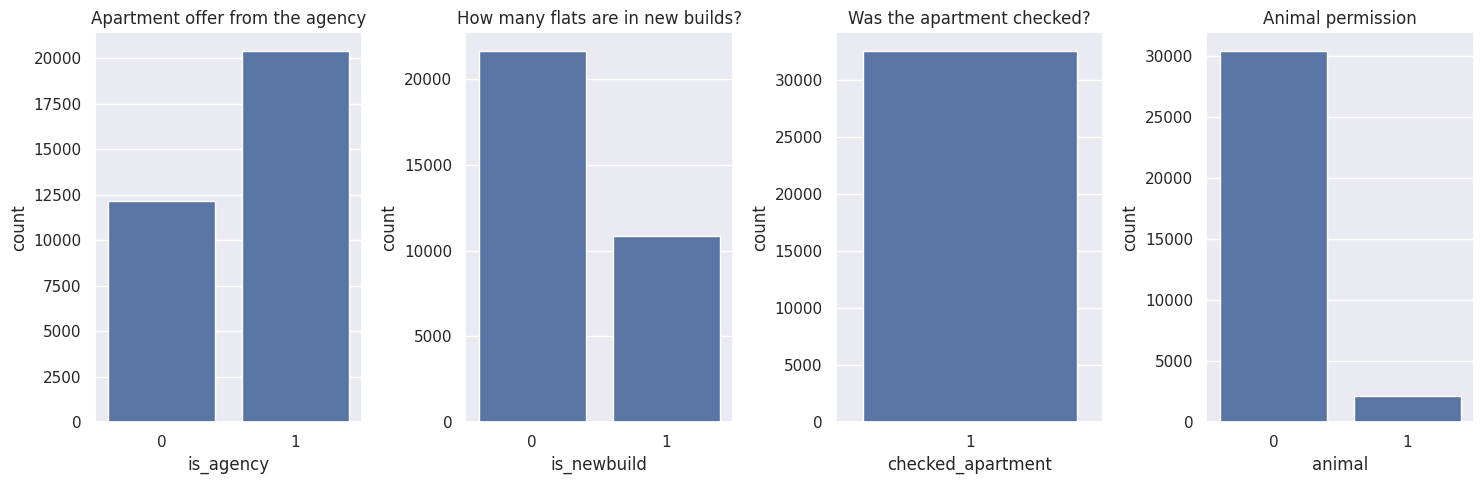

In [27]:
f, axes = plt.subplots(1, 4, figsize=(15, 5))

sns.countplot(data=df, x='is_agency', ax=axes[0])
axes[0].set_title('Apartment offer from the agency')

sns.countplot(data=df, x='is_newbuild', ax=axes[1])
axes[1].set_title('How many flats are in new builds?')

sns.countplot(data=df, x='checked_apartment', ax=axes[2])
axes[2].set_title('Was the apartment checked?')

sns.countplot(data=df, x='animal', ax=axes[3])
axes[3].set_title('Animal permission')

plt.tight_layout()
plt.show()

We see from plots that all apartment was checked and really small animal permission!

In [28]:
subway_t = df[df['subway'] == True]['city_name'].value_counts().reset_index()
subway_t.rename(columns={'count': 'subway_True'}, inplace=True)
cities_with_subway = subway_t['city_name'].unique()
subway_all = df[df['city_name'].isin(cities_with_subway)]['city_name'].value_counts().reset_index()
subway_all.rename(columns={'count': 'all_apartment'}, inplace=True)

subway_df = subway_t.merge(subway_all, how='inner', on='city_name')
subway_df['percentage_%'] = np.round(subway_df['subway_True'] / subway_df['all_apartment'], 2)
subway_df

city_name  subway_True  all_apartment  percentage_%
0        Київ         5129           7701          0.67
1      Харків         2306           3127          0.74
2      Дніпро          308           2559          0.12
3  Кривий Ріг          229            764          0.30

Kryvyi Rih has what appears to be a subway, but it's actually the Kryvyi Rih Rapid Tram, a large transport network built to metro standards. But it also can effect on real estate price so, leave it in our data.

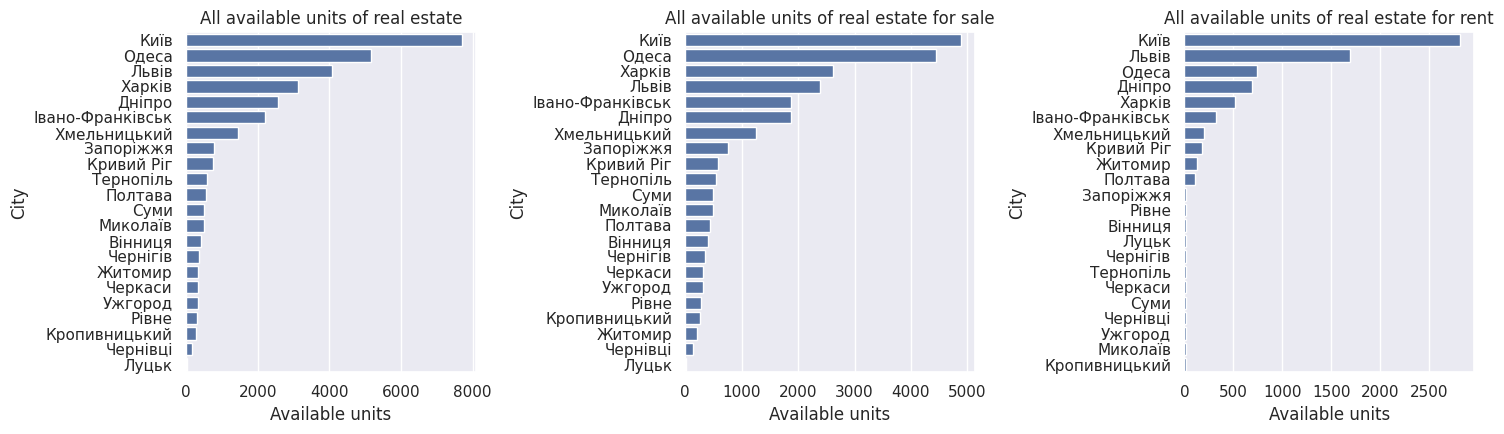

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))


sns.countplot(data=df, y='city_name',
              order=df['city_name'].value_counts().index,
              ax=ax[0])

ax[0].set_title('All available units of real estate')
ax[0].set_xlabel('Available units')
ax[0].set_ylabel('City')


sns.countplot(data=df[df['deal_type']=='Sale'],
              y='city_name',
              order=df[df['deal_type']=='Sale']['city_name'].value_counts().index,
              ax=ax[1])

ax[1].set_title('All available units of real estate for sale')
ax[1].set_xlabel('Available units')
ax[1].set_ylabel('City')


sns.countplot(data=df[df['deal_type']=='Rent'],
              y='city_name',
              order=df[df['deal_type']=='Rent']['city_name'].value_counts().index,
              ax=ax[2])

ax[2].set_title('All available units of real estate for rent')
ax[2].set_xlabel('Available units')
ax[2].set_ylabel('City')

plt.tight_layout()
plt.show()

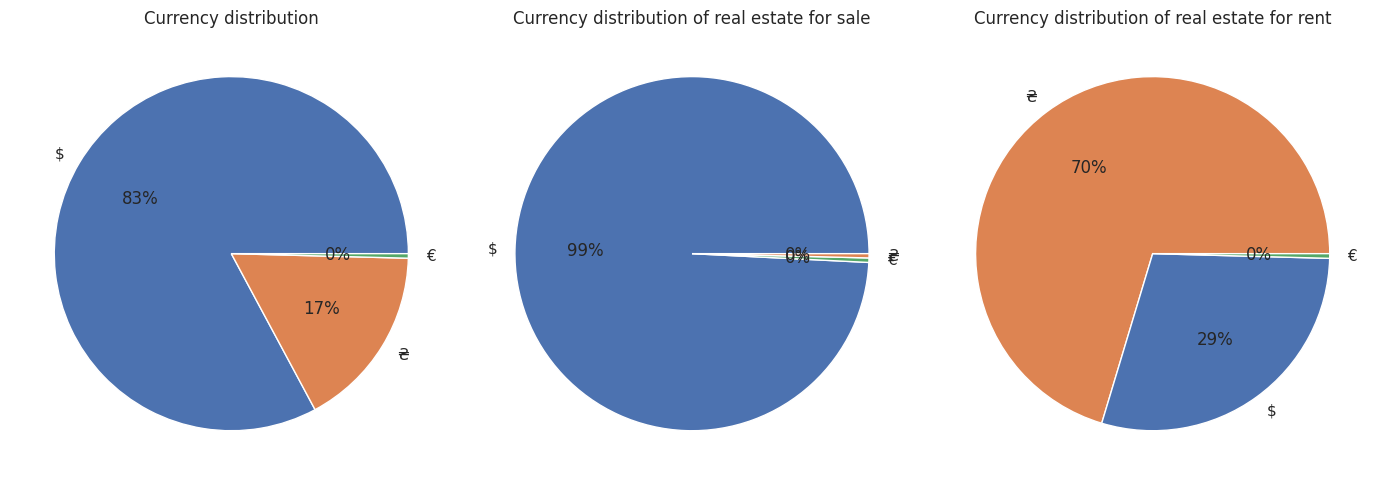

In [30]:
palette = sns.color_palette("deep")
unique_currencies = df['currency'].value_counts().index
currency_colors = {currency: palette[i] for i, currency in enumerate(unique_currencies)}

def get_colors(values):
    return [currency_colors[val] for val in values]


fig, ax = plt.subplots(1, 3, figsize=(14, 5))
currency_counts = df['currency'].value_counts()
ax[0].pie(currency_counts, labels=currency_counts.index, autopct='%.0f%%',
          colors=get_colors(currency_counts.index))
ax[0].set_title('Currency distribution')


currency_counts_sale = df[df['deal_type'] == 'Sale']['currency'].value_counts()
ax[1].pie(currency_counts_sale, labels=currency_counts_sale.index, autopct='%.0f%%',
          colors=get_colors(currency_counts_sale.index))
ax[1].set_title('Currency distribution of real estate for sale')


currency_counts_rent = df[df['deal_type'] == 'Rent']['currency'].value_counts()
ax[2].pie(currency_counts_rent, labels=currency_counts_rent.index, autopct='%.0f%%',
          colors=get_colors(currency_counts_rent.index))
ax[2].set_title('Currency distribution of real estate for rent')


plt.tight_layout()
plt.show()

We observe that real estate sales market estimates are consistently in dollars. In contrast, the rental market frequently uses the national currency for flat real estate valuations, possibly reflecting the short-term duration of the deal.

## Rent/price different statistic

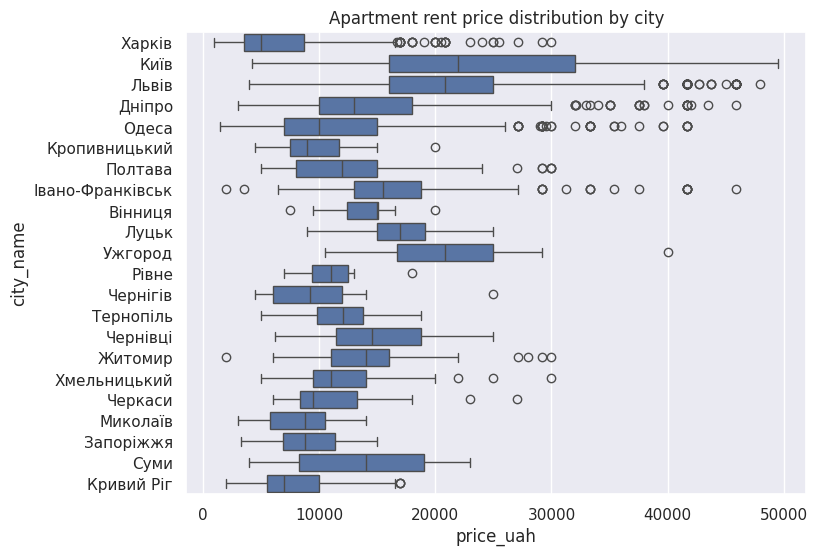

In [31]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df[df['deal_type']=='Rent'], x='price_uah', y='city_name')
plt.title('Apartment rent price distribution by city')
plt.show()

It's extremely interesting that the median rent price in Kharkiv is the lowest among the big cities in Ukraine. Uzhhorod and Lviv show some competition with Kyiv.

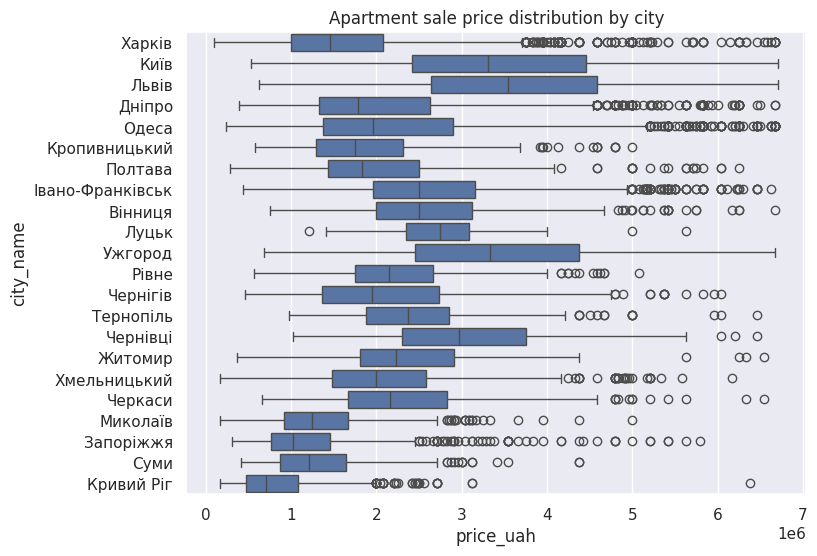

In [32]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df[df['deal_type']=='Sale'], x='price_uah', y='city_name')
plt.title('Apartment sale price distribution by city')
plt.show()

We see that in long-term deals – for sales – Kharkiv appears slightly higher in the tier list. It's also interesting that Lviv has the highest median sale price, not Kyiv, which could be related to the perceived safety of the city. Uzhhorod also ranks in the top3 for high apartment sale prices.

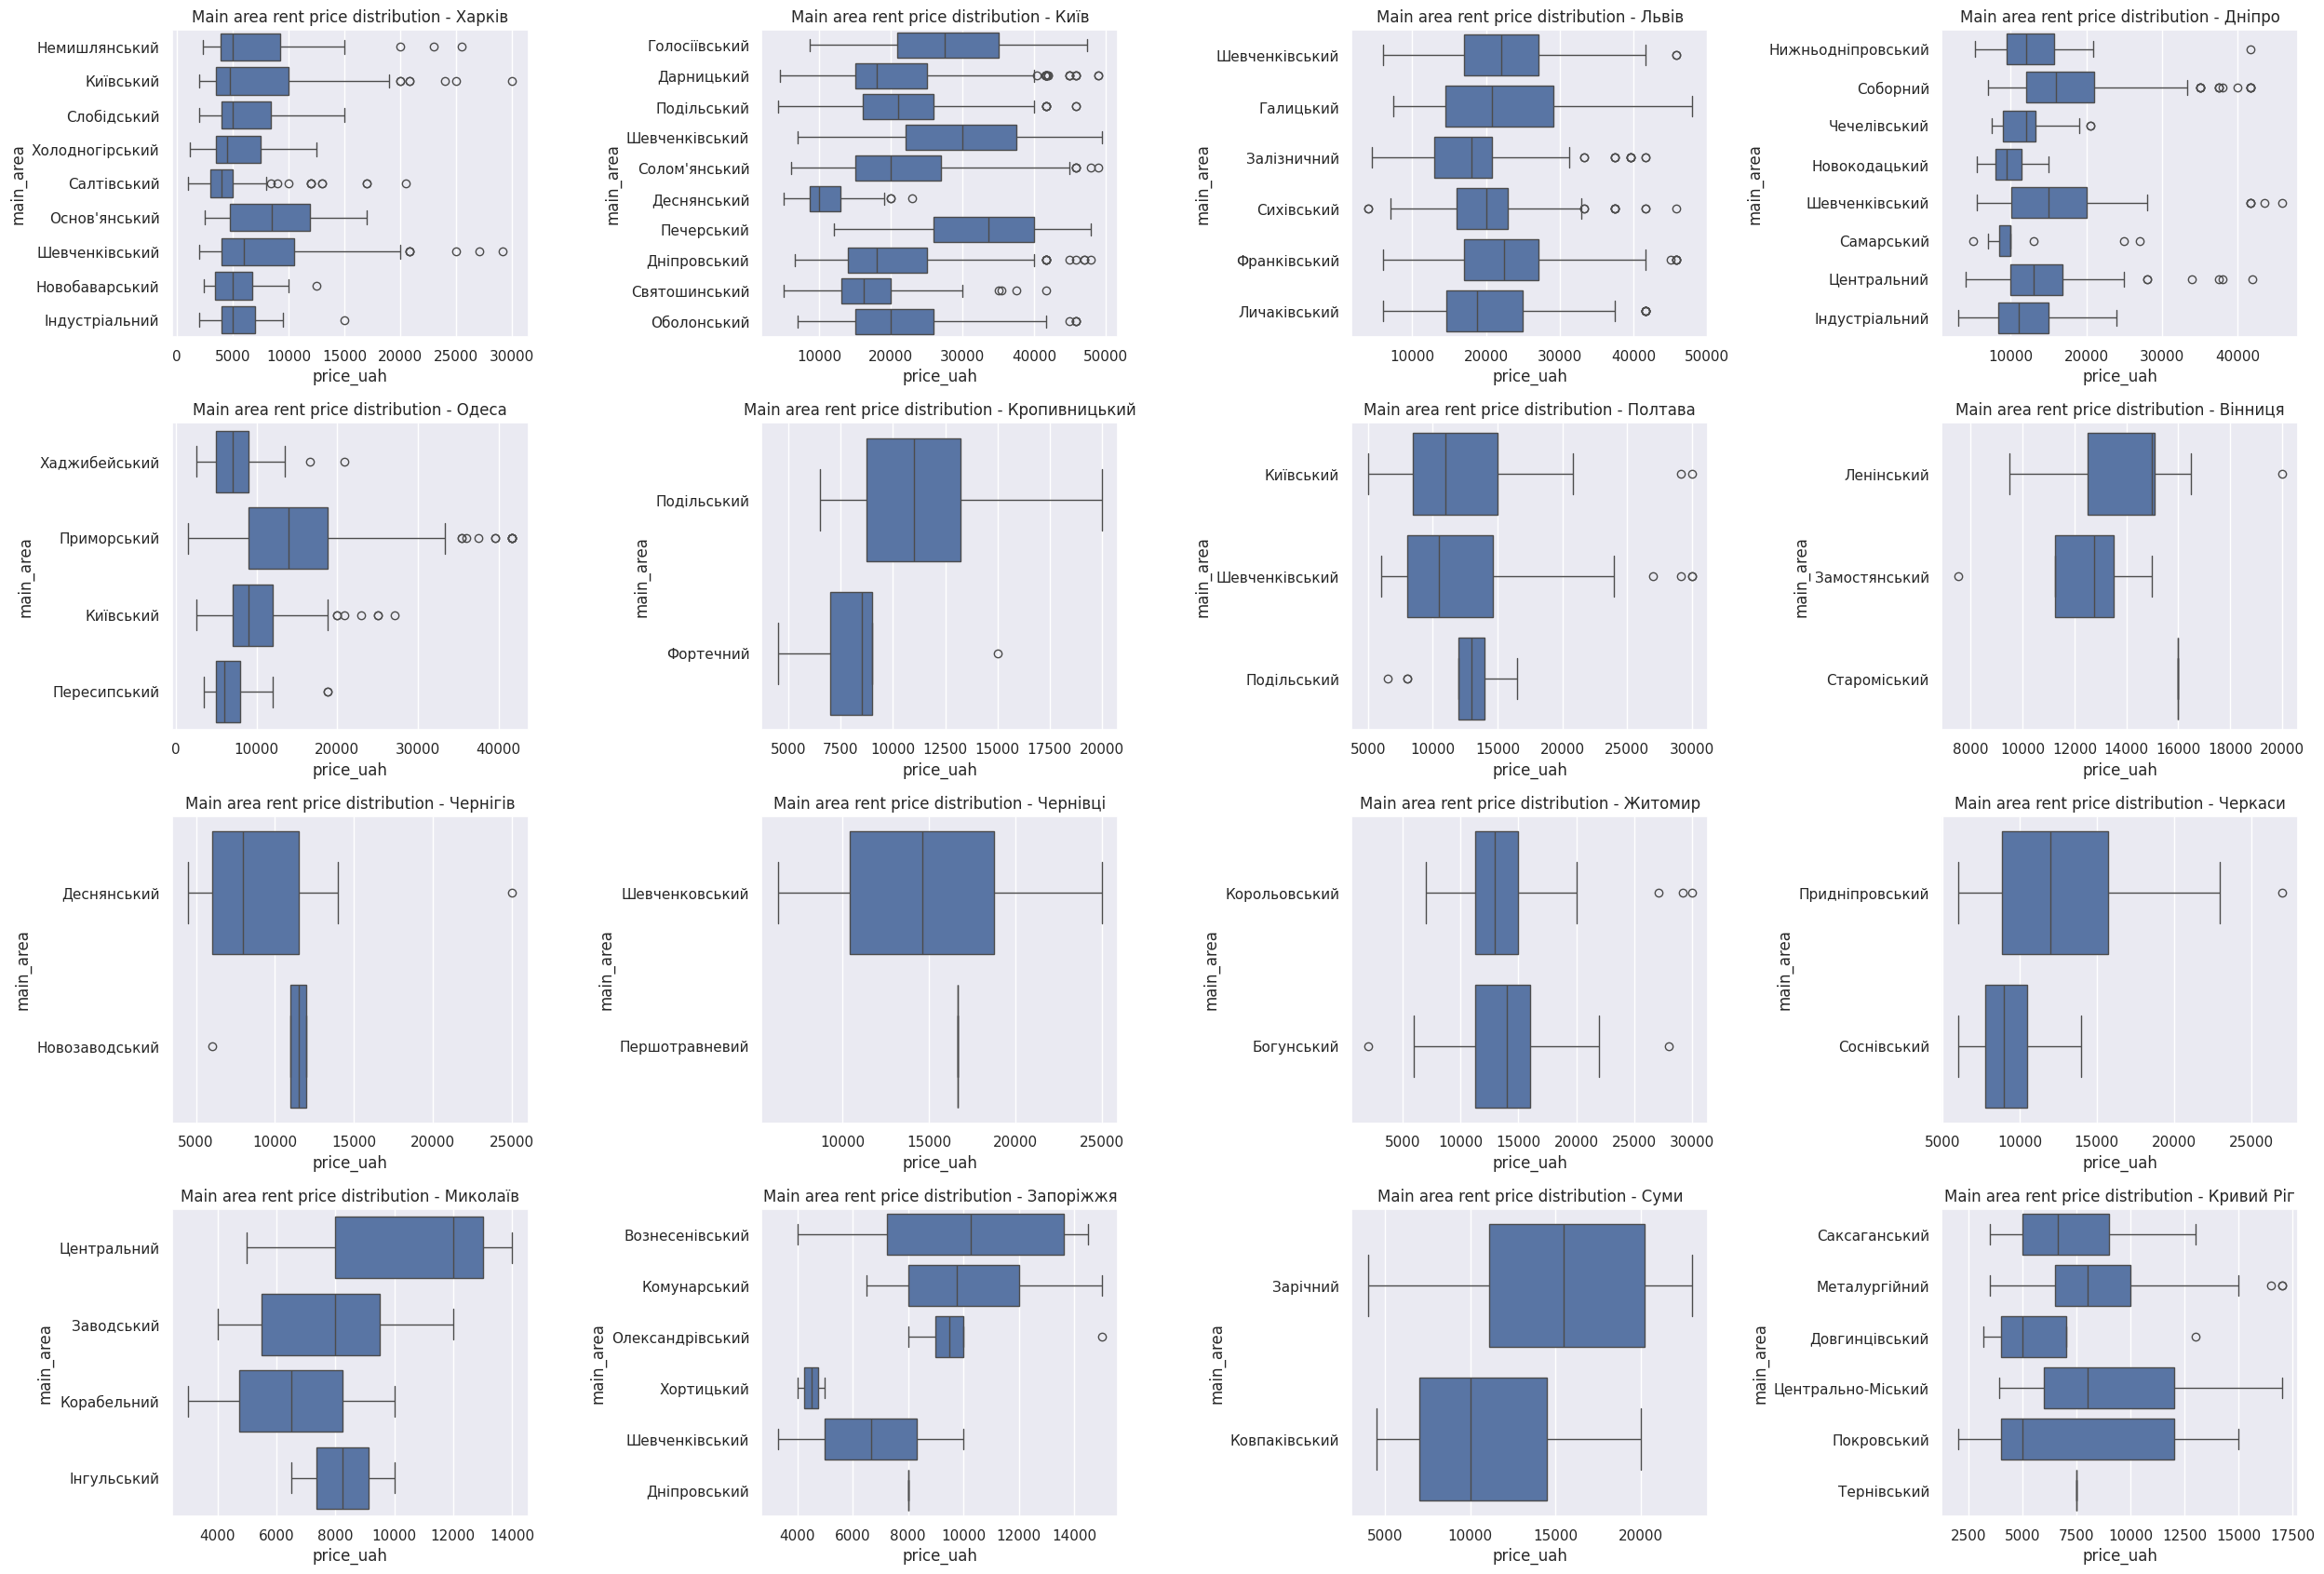

In [33]:
cities = df['city_name'].unique()
f, axes = plt.subplots(6, 4, figsize=(25, 25))
axes = axes.flatten()

plot_idx = 0
for city in cities:
    temp_df = df[(df['city_name'] == city) & (df['deal_type'] == 'Rent')]
    if temp_df['main_area'].notna().sum() == 0:
        continue
    sns.boxplot(data=temp_df, x='price_uah', y='main_area', ax=axes[plot_idx])
    axes[plot_idx].set_title(f'Main area rent price distribution - {city}')
    plot_idx += 1

for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

It's noticeable that certain cities have just one (or not many) records for each area. Also, some cities don't have any official administrative areas, so there are only unofficial ones.

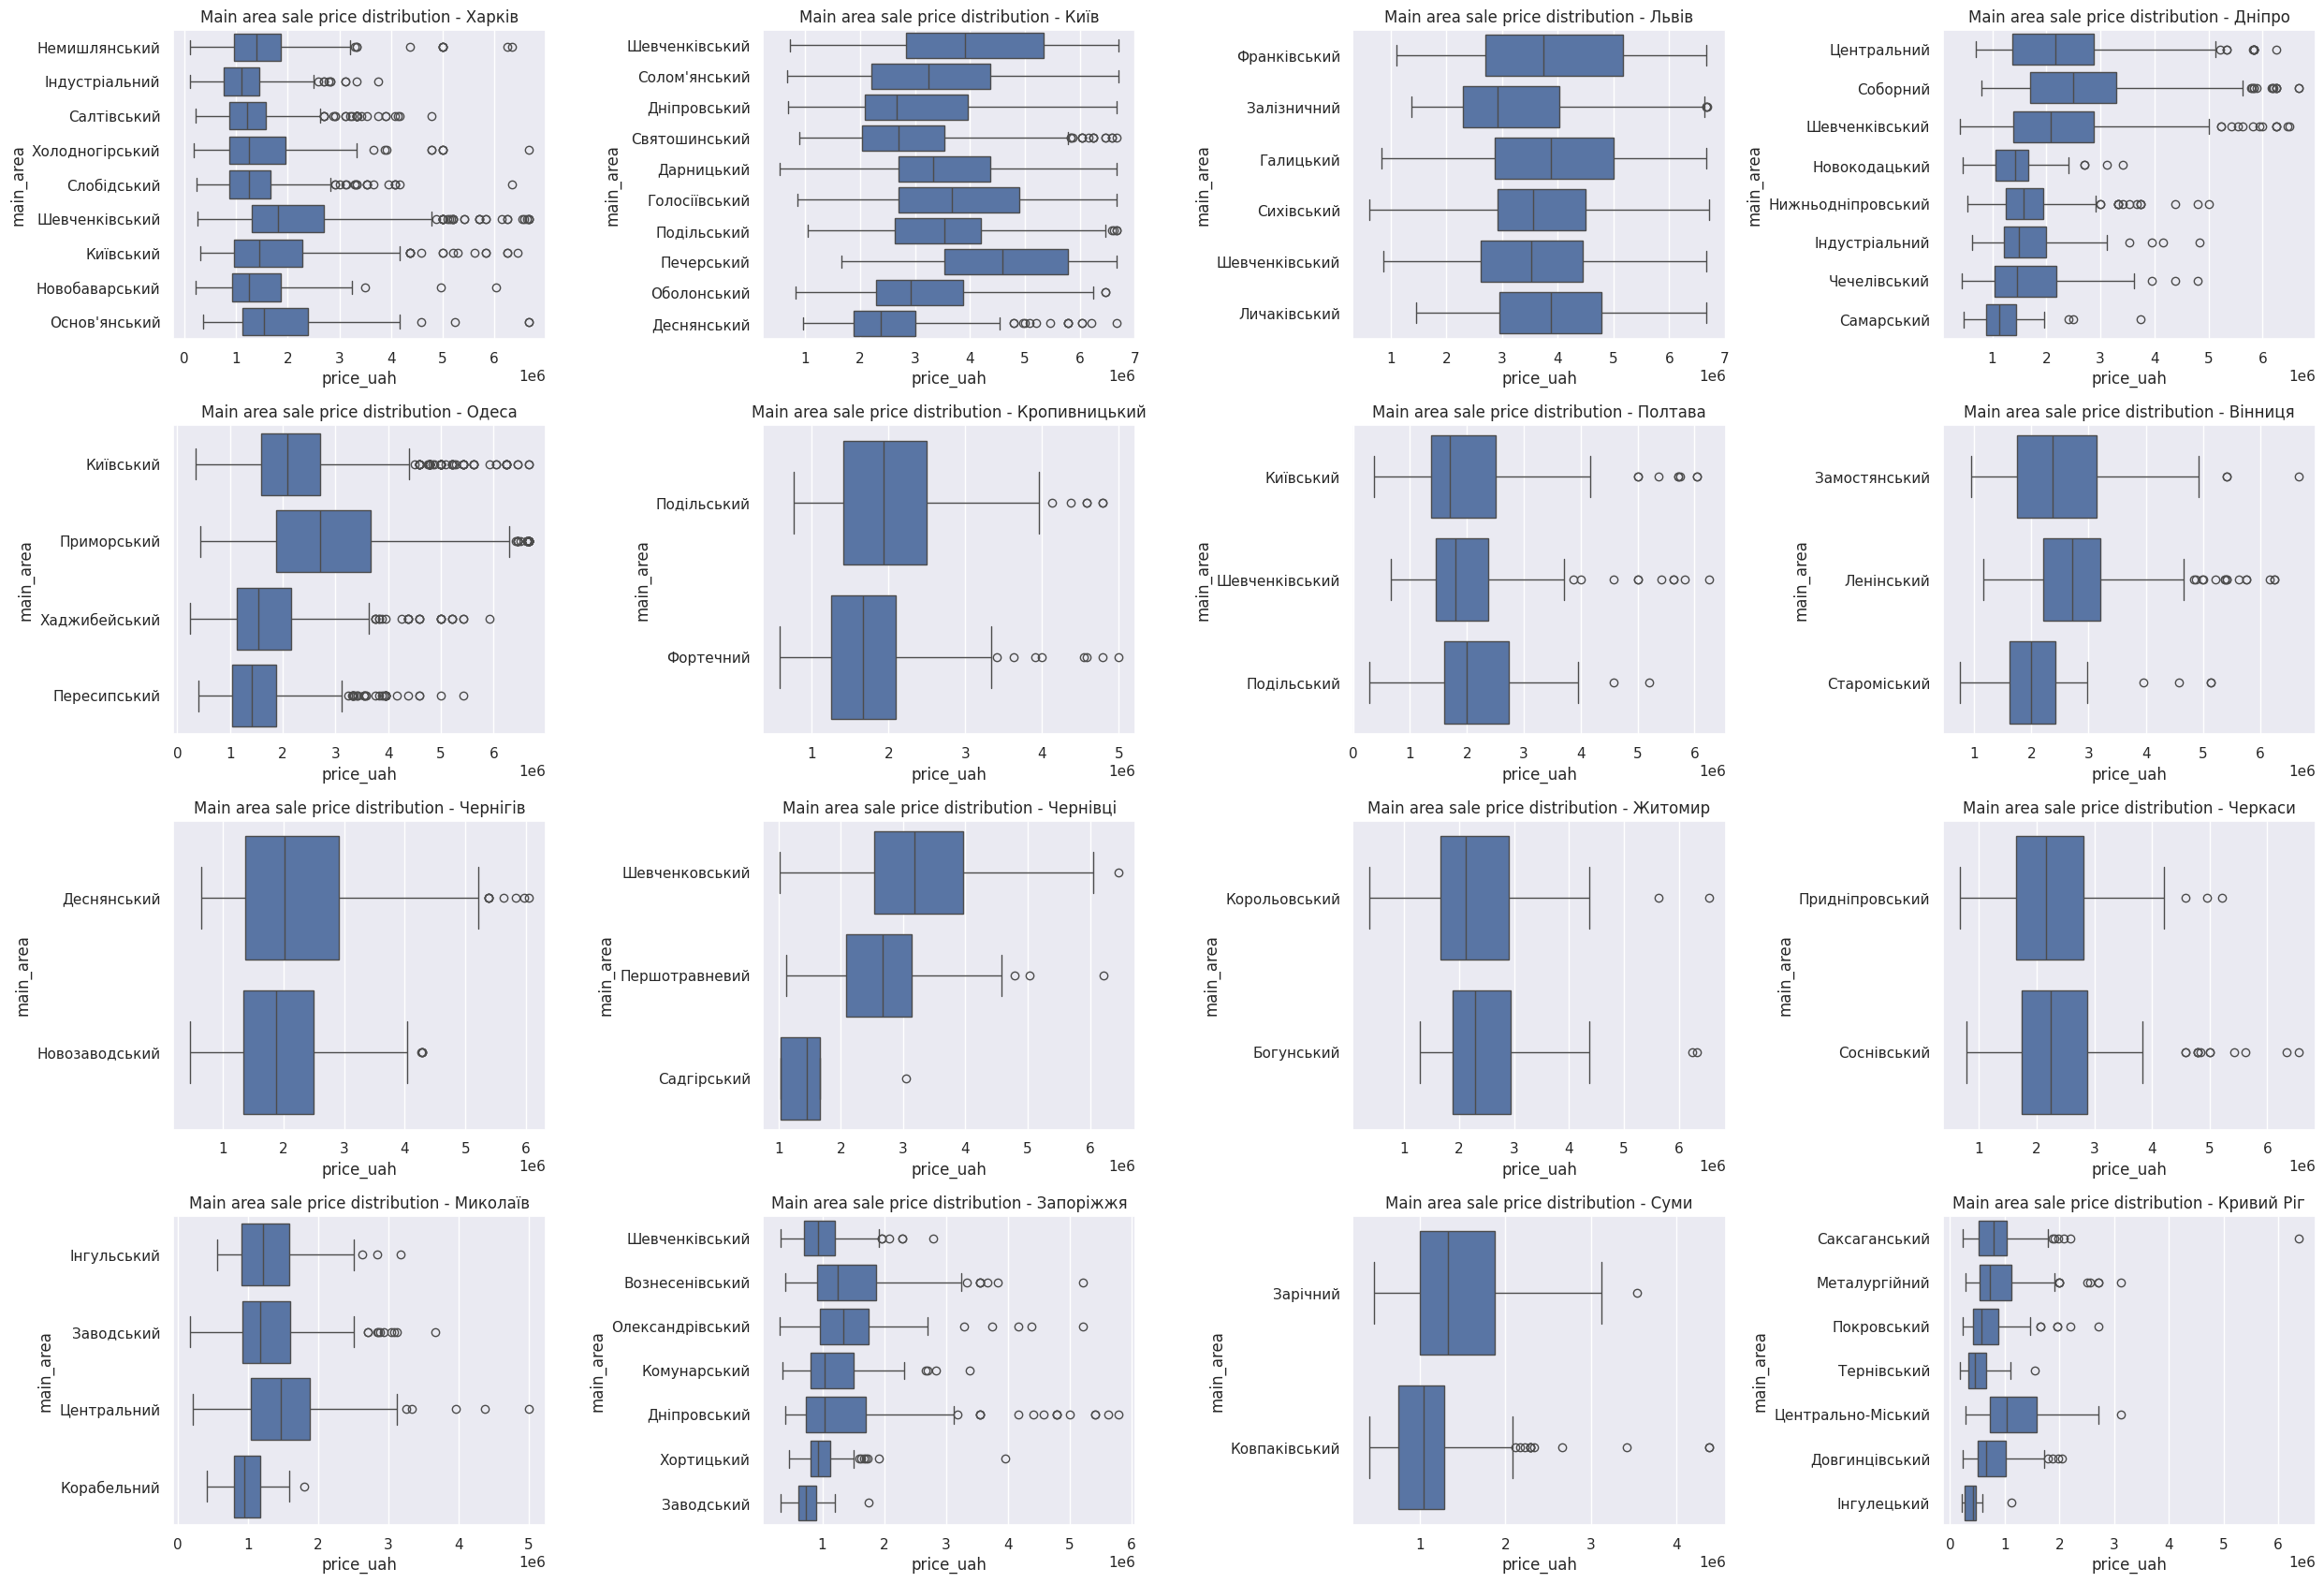

In [34]:
f, axes = plt.subplots(6, 4, figsize=(25, 25))
axes = axes.flatten()

plot_idx = 0
for city in cities:
    temp_df = df[(df['city_name'] == city) & (df['deal_type'] == 'Sale')]
    if temp_df['main_area'].notna().sum() == 0:
        continue
    sns.boxplot(data=temp_df, x='price_uah', y='main_area', ax=axes[plot_idx])
    axes[plot_idx].set_title(f'Main area sale price distribution - {city}')
    plot_idx += 1

for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

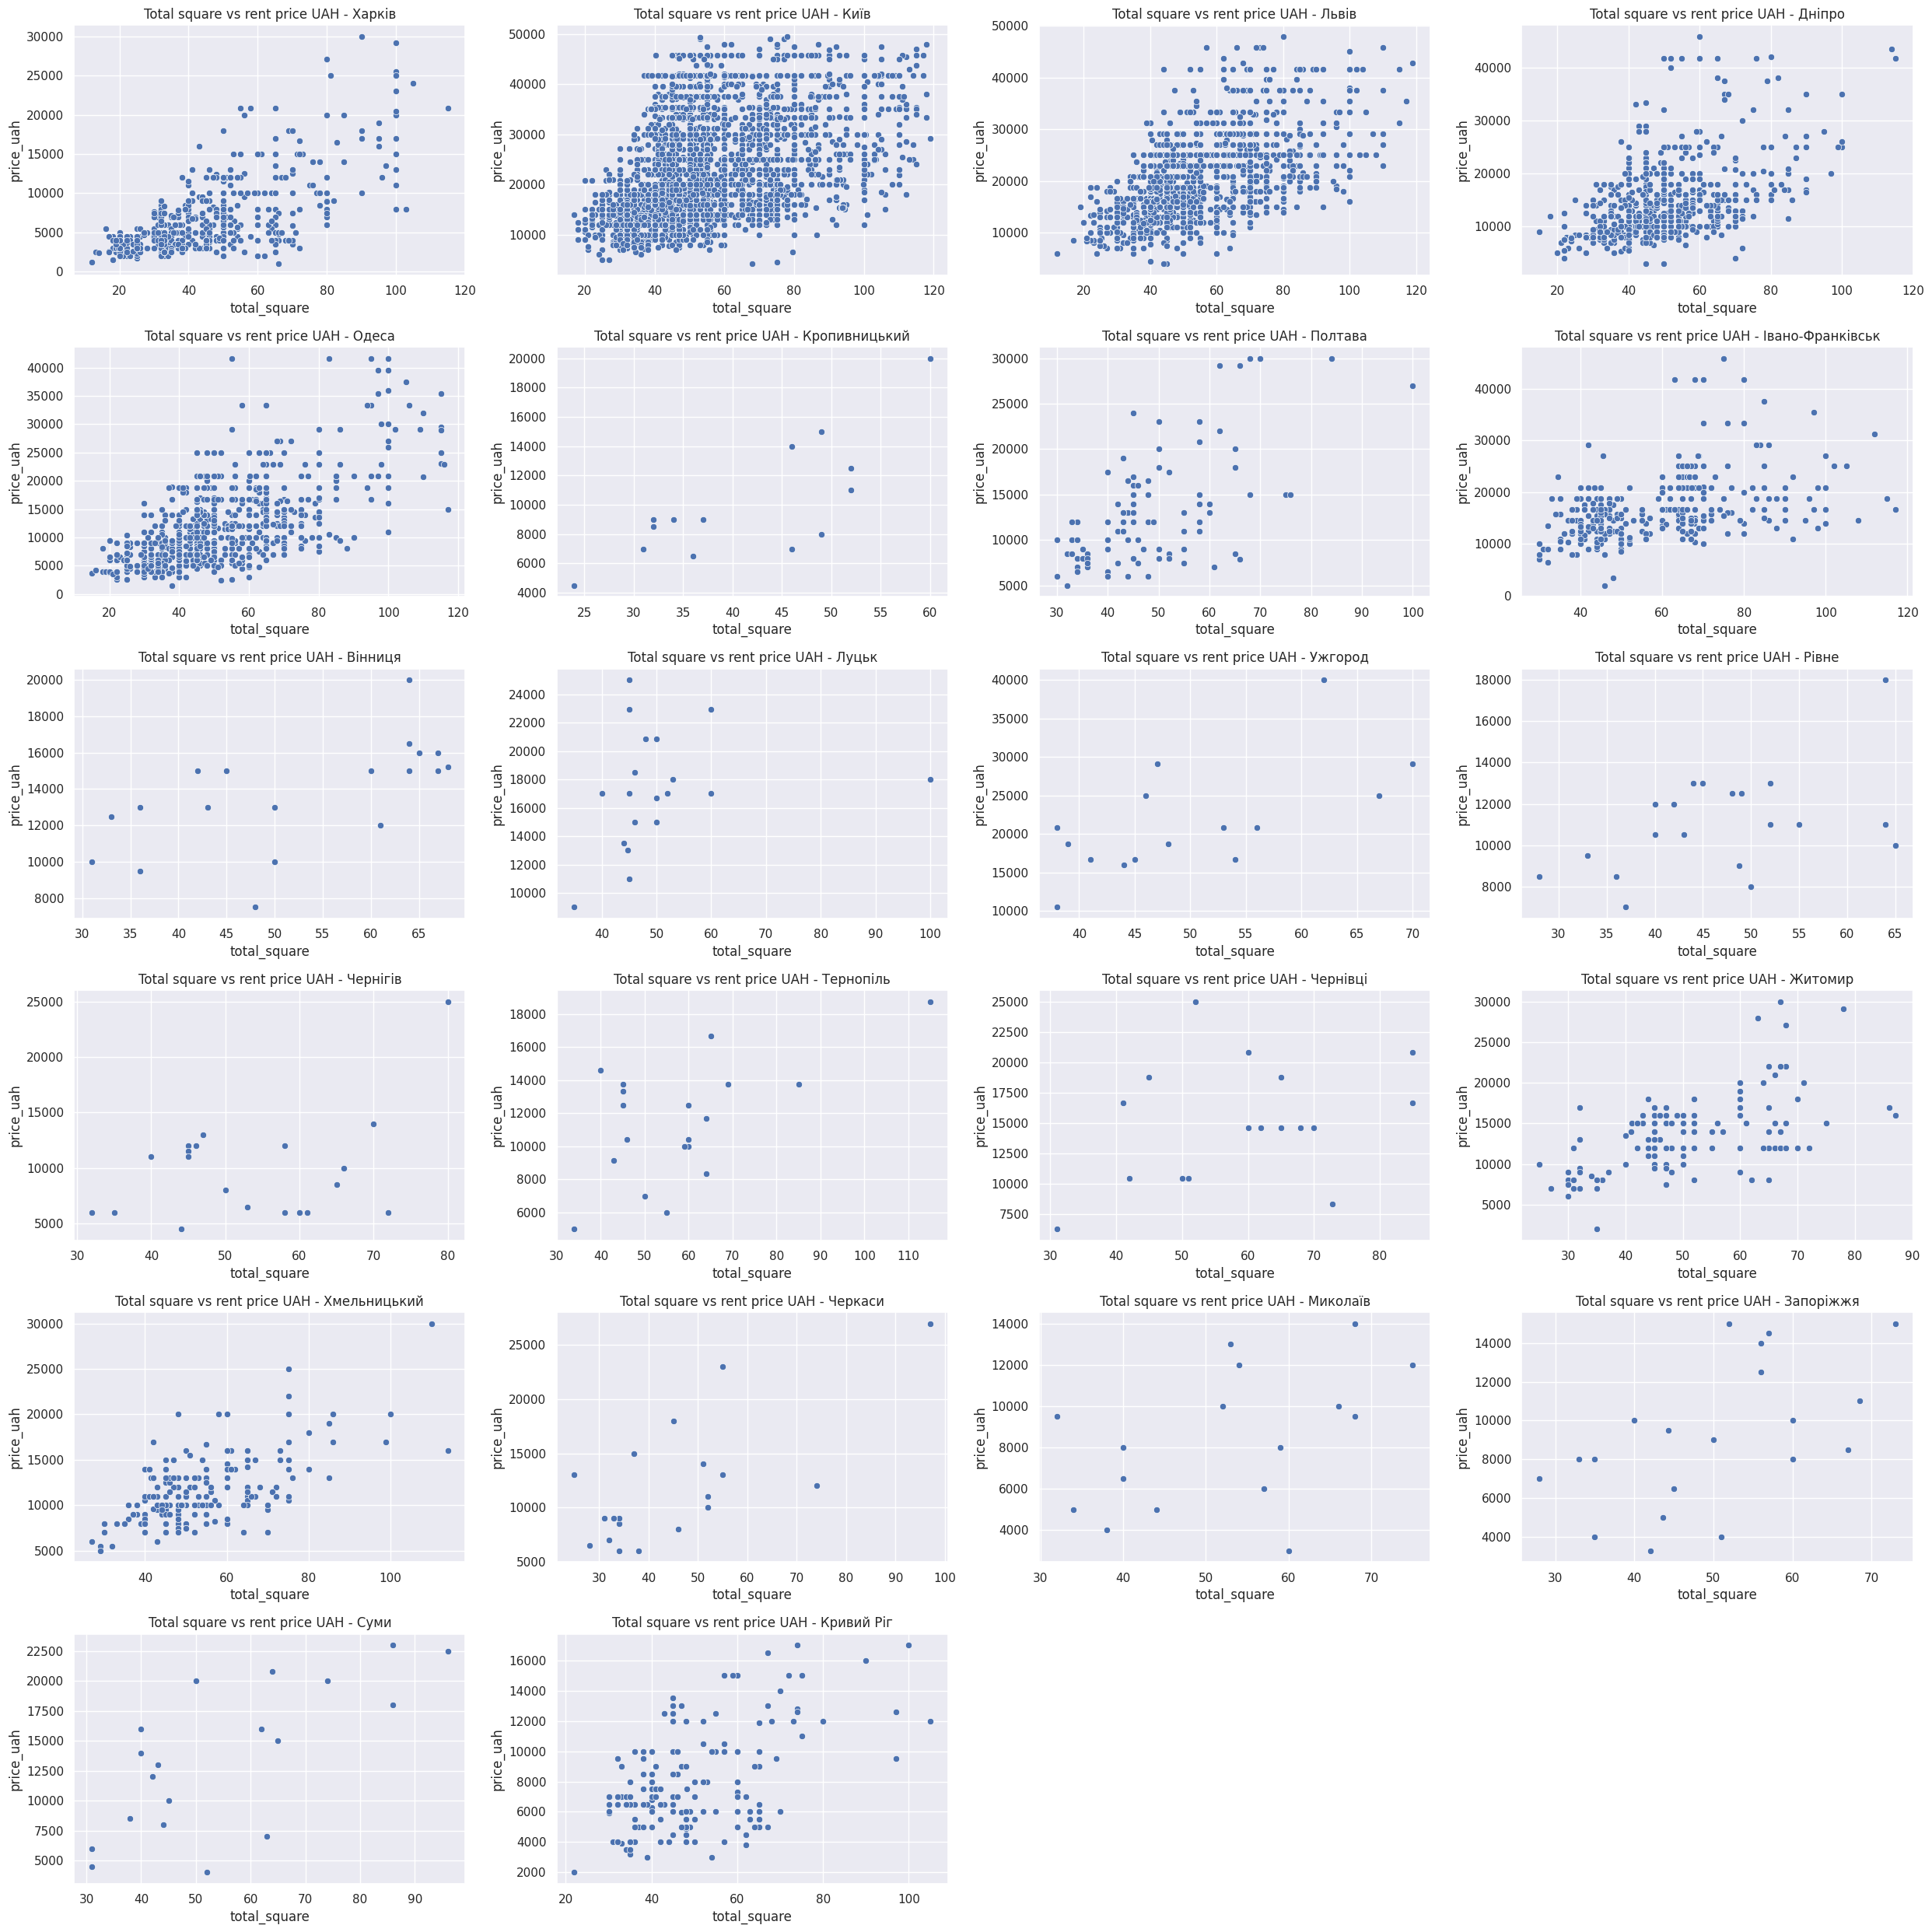

In [35]:
f, axes = plt.subplots(6, 4, figsize=(25, 25))
axes = axes.flatten()

plot_idx = 0
for city in cities:
    temp_df = df[(df['city_name'] == city) & (df['deal_type'] == 'Rent')]
    sns.scatterplot(data=temp_df, x='total_square', y='price_uah', ax=axes[plot_idx])
    axes[plot_idx].set_title(f'Total square vs rent price UAH - {city}')
    plot_idx += 1

for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

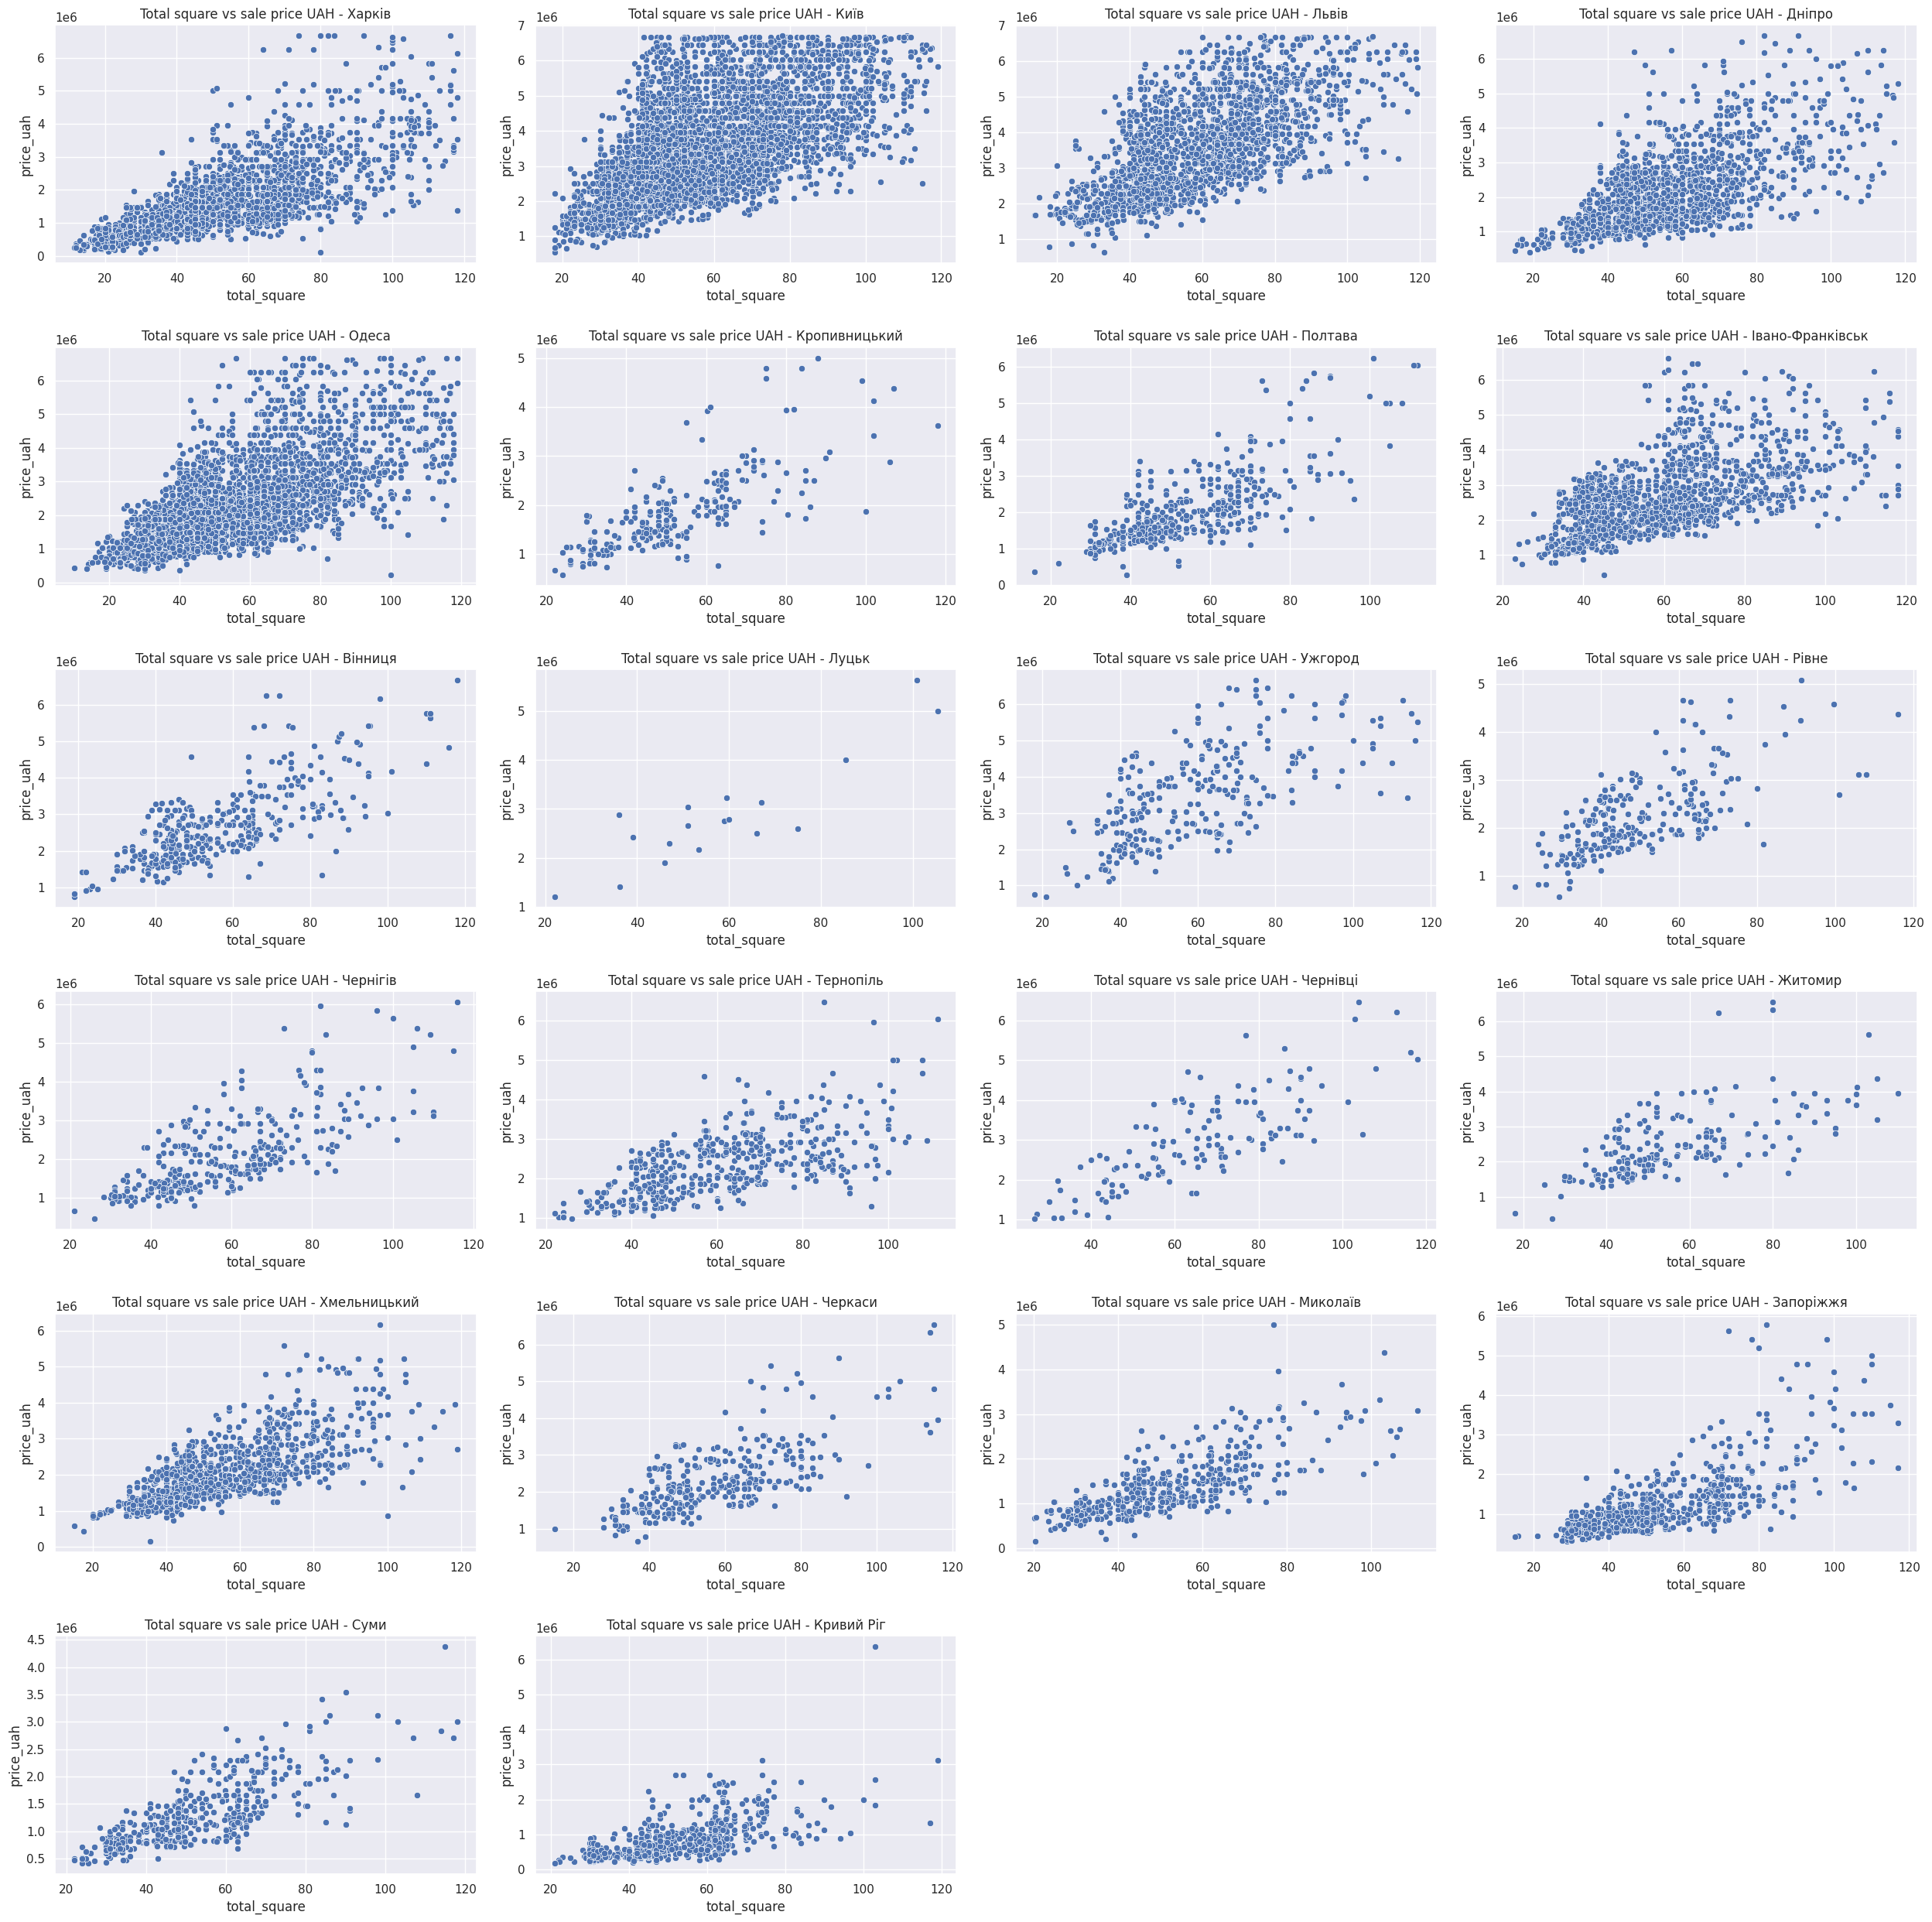

In [36]:
f, axes = plt.subplots(6, 4, figsize=(25, 25))
axes = axes.flatten()

plot_idx = 0
for city in cities:
    temp_df = df[(df['city_name'] == city) & (df['deal_type'] == 'Sale')]
    sns.scatterplot(data=temp_df, x='total_square', y='price_uah', ax=axes[plot_idx])
    axes[plot_idx].set_title(f'Total square vs sale price UAH - {city}')
    plot_idx += 1

for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

You can see that for sales, there's a much clearer straight-line connection between total square and price (UAH) by city than for rentals. This indicates that other things we don't have data on affect rental prices more.

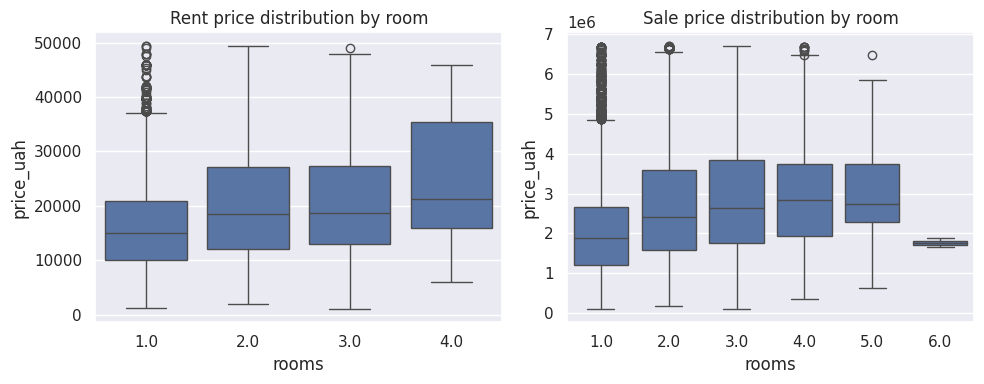

In [37]:
f, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(data=df[df['deal_type']=='Rent'], x='rooms', y='price_uah', ax=axes[0])
axes[0].set_title('Rent price distribution by room')

sns.boxplot(data=df[df['deal_type']=='Sale'], x='rooms', y='price_uah', ax=axes[1])
axes[1].set_title('Sale price distribution by room')

plt.tight_layout()
plt.show()

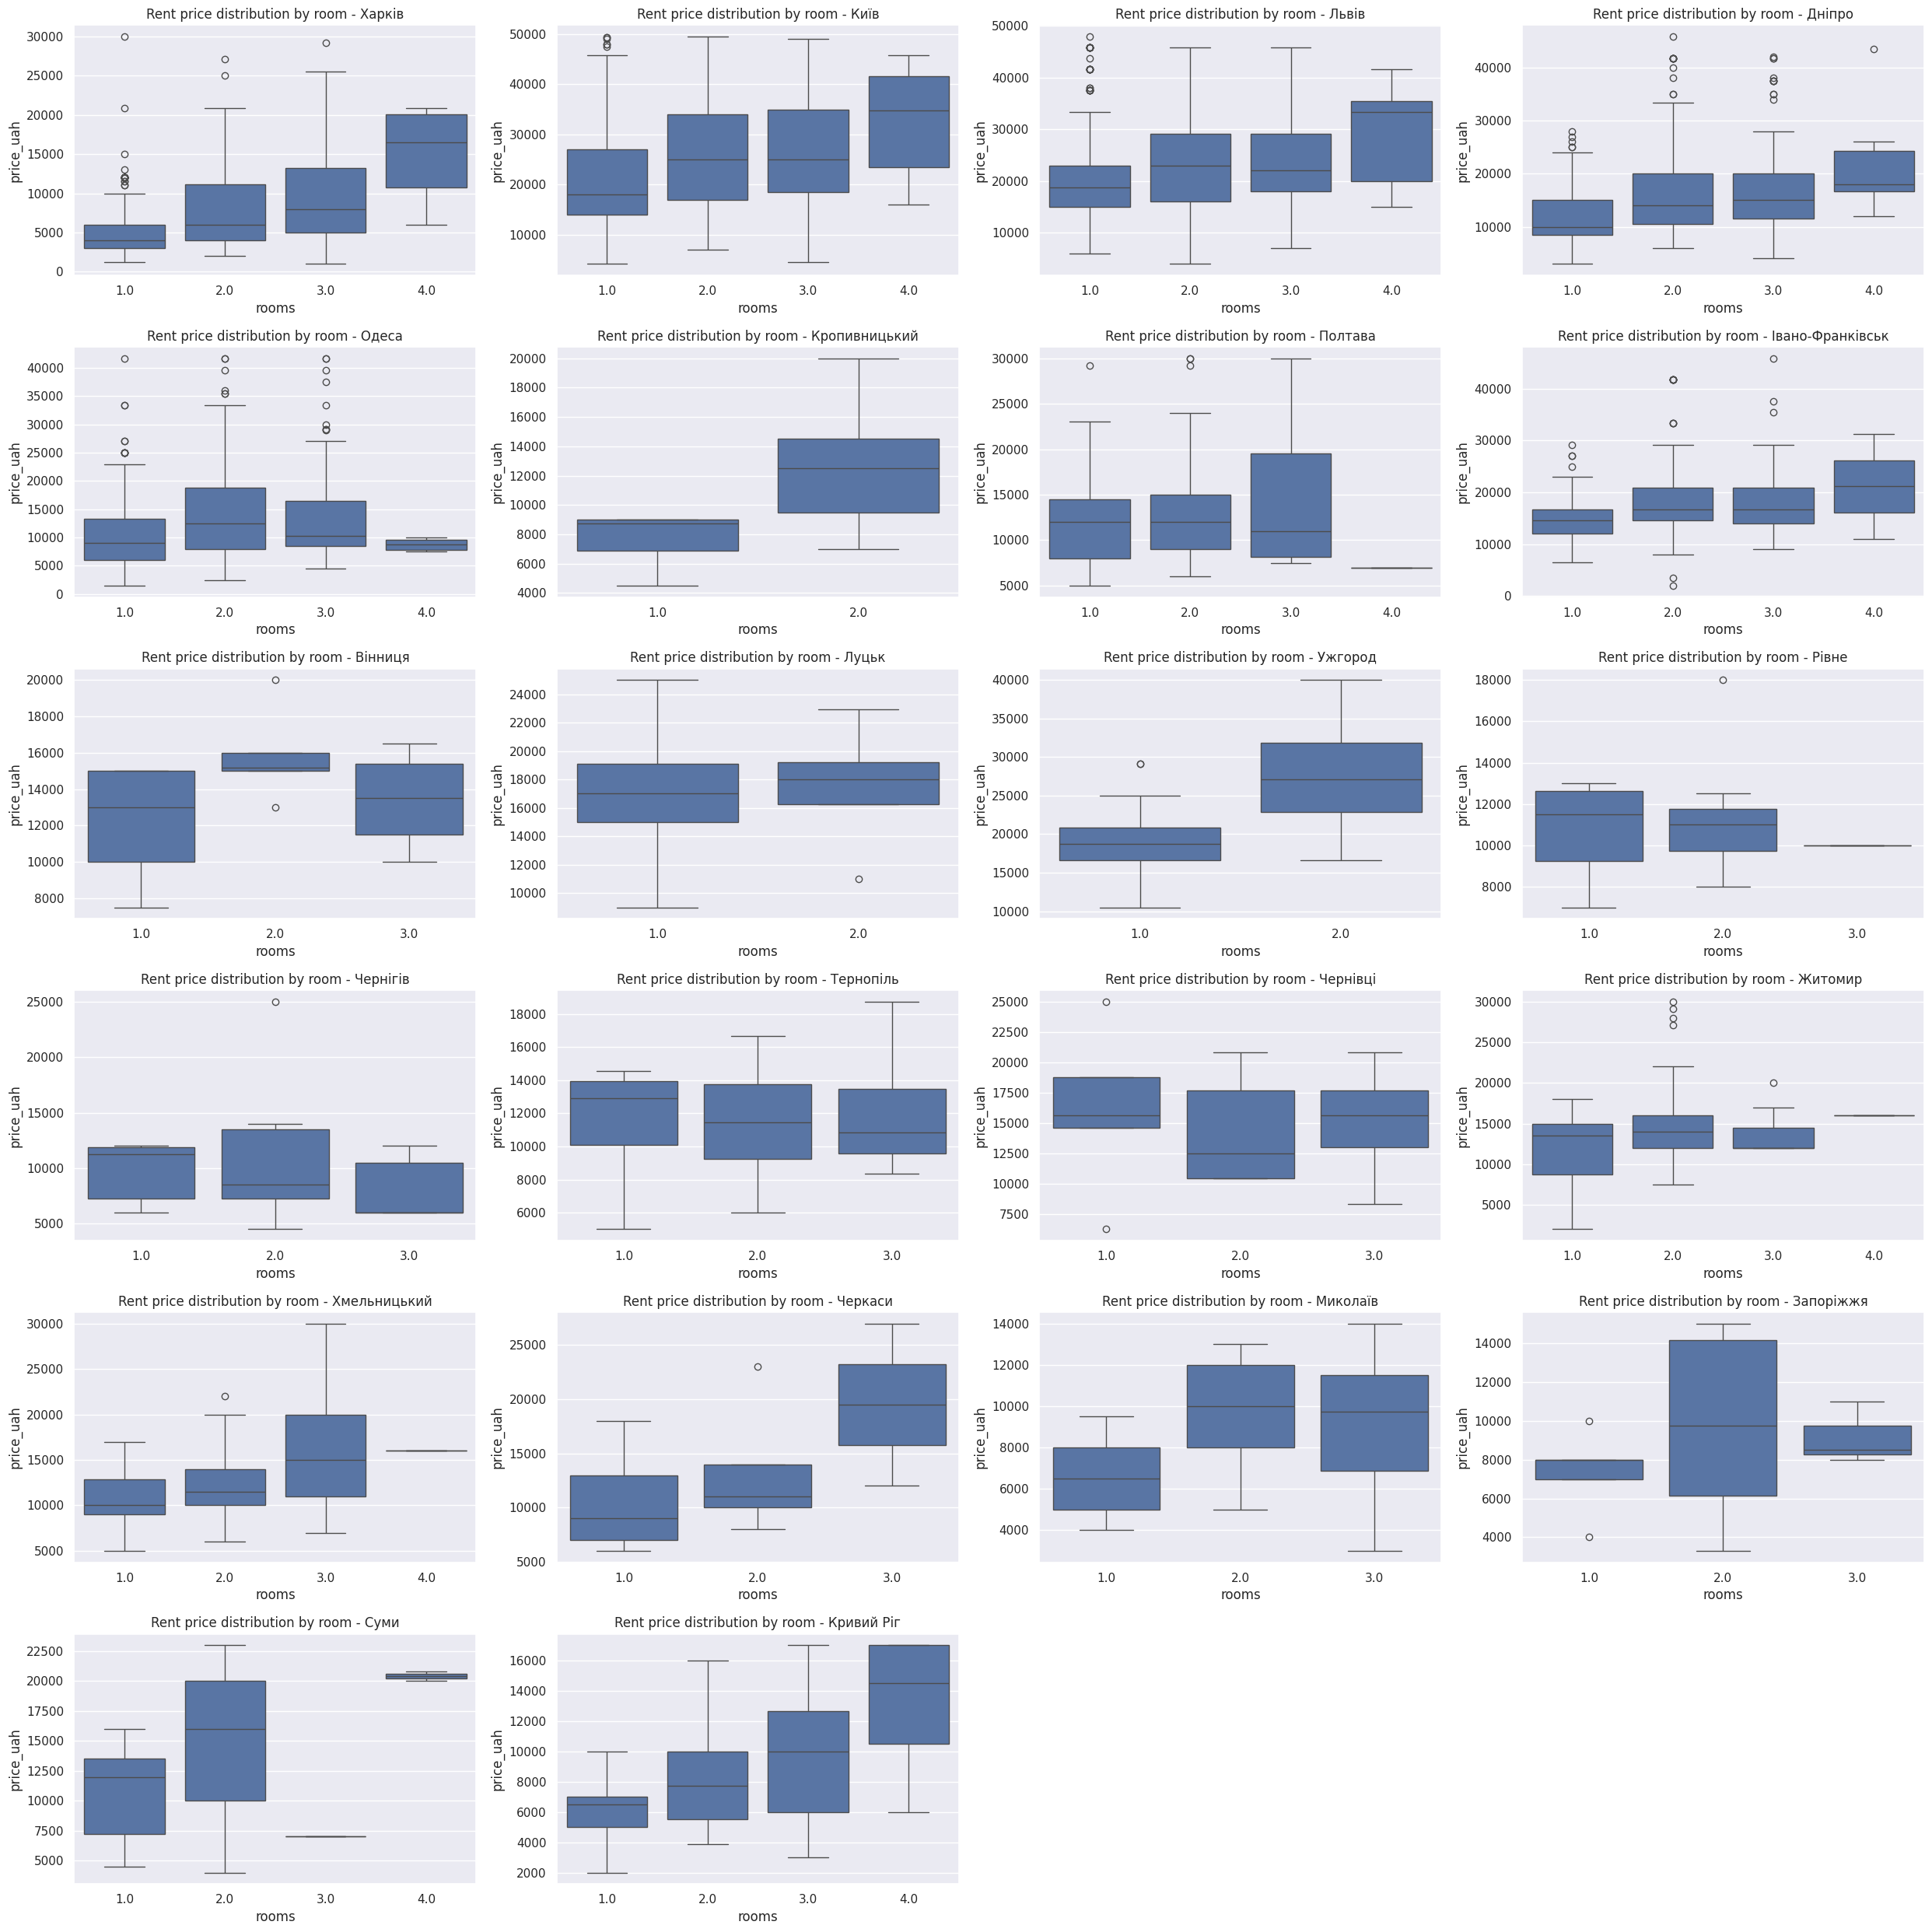

In [38]:
f, axes = plt.subplots(6, 4, figsize=(25, 25))
axes = axes.flatten()

plot_idx = 0
for city in cities:
    temp_df = df[(df['city_name'] == city) & (df['deal_type'] == 'Rent')]
    sns.boxplot(data=temp_df, x='rooms', y='price_uah', ax=axes[plot_idx])
    axes[plot_idx].set_title(f'Rent price distribution by room - {city}')
    plot_idx += 1

for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

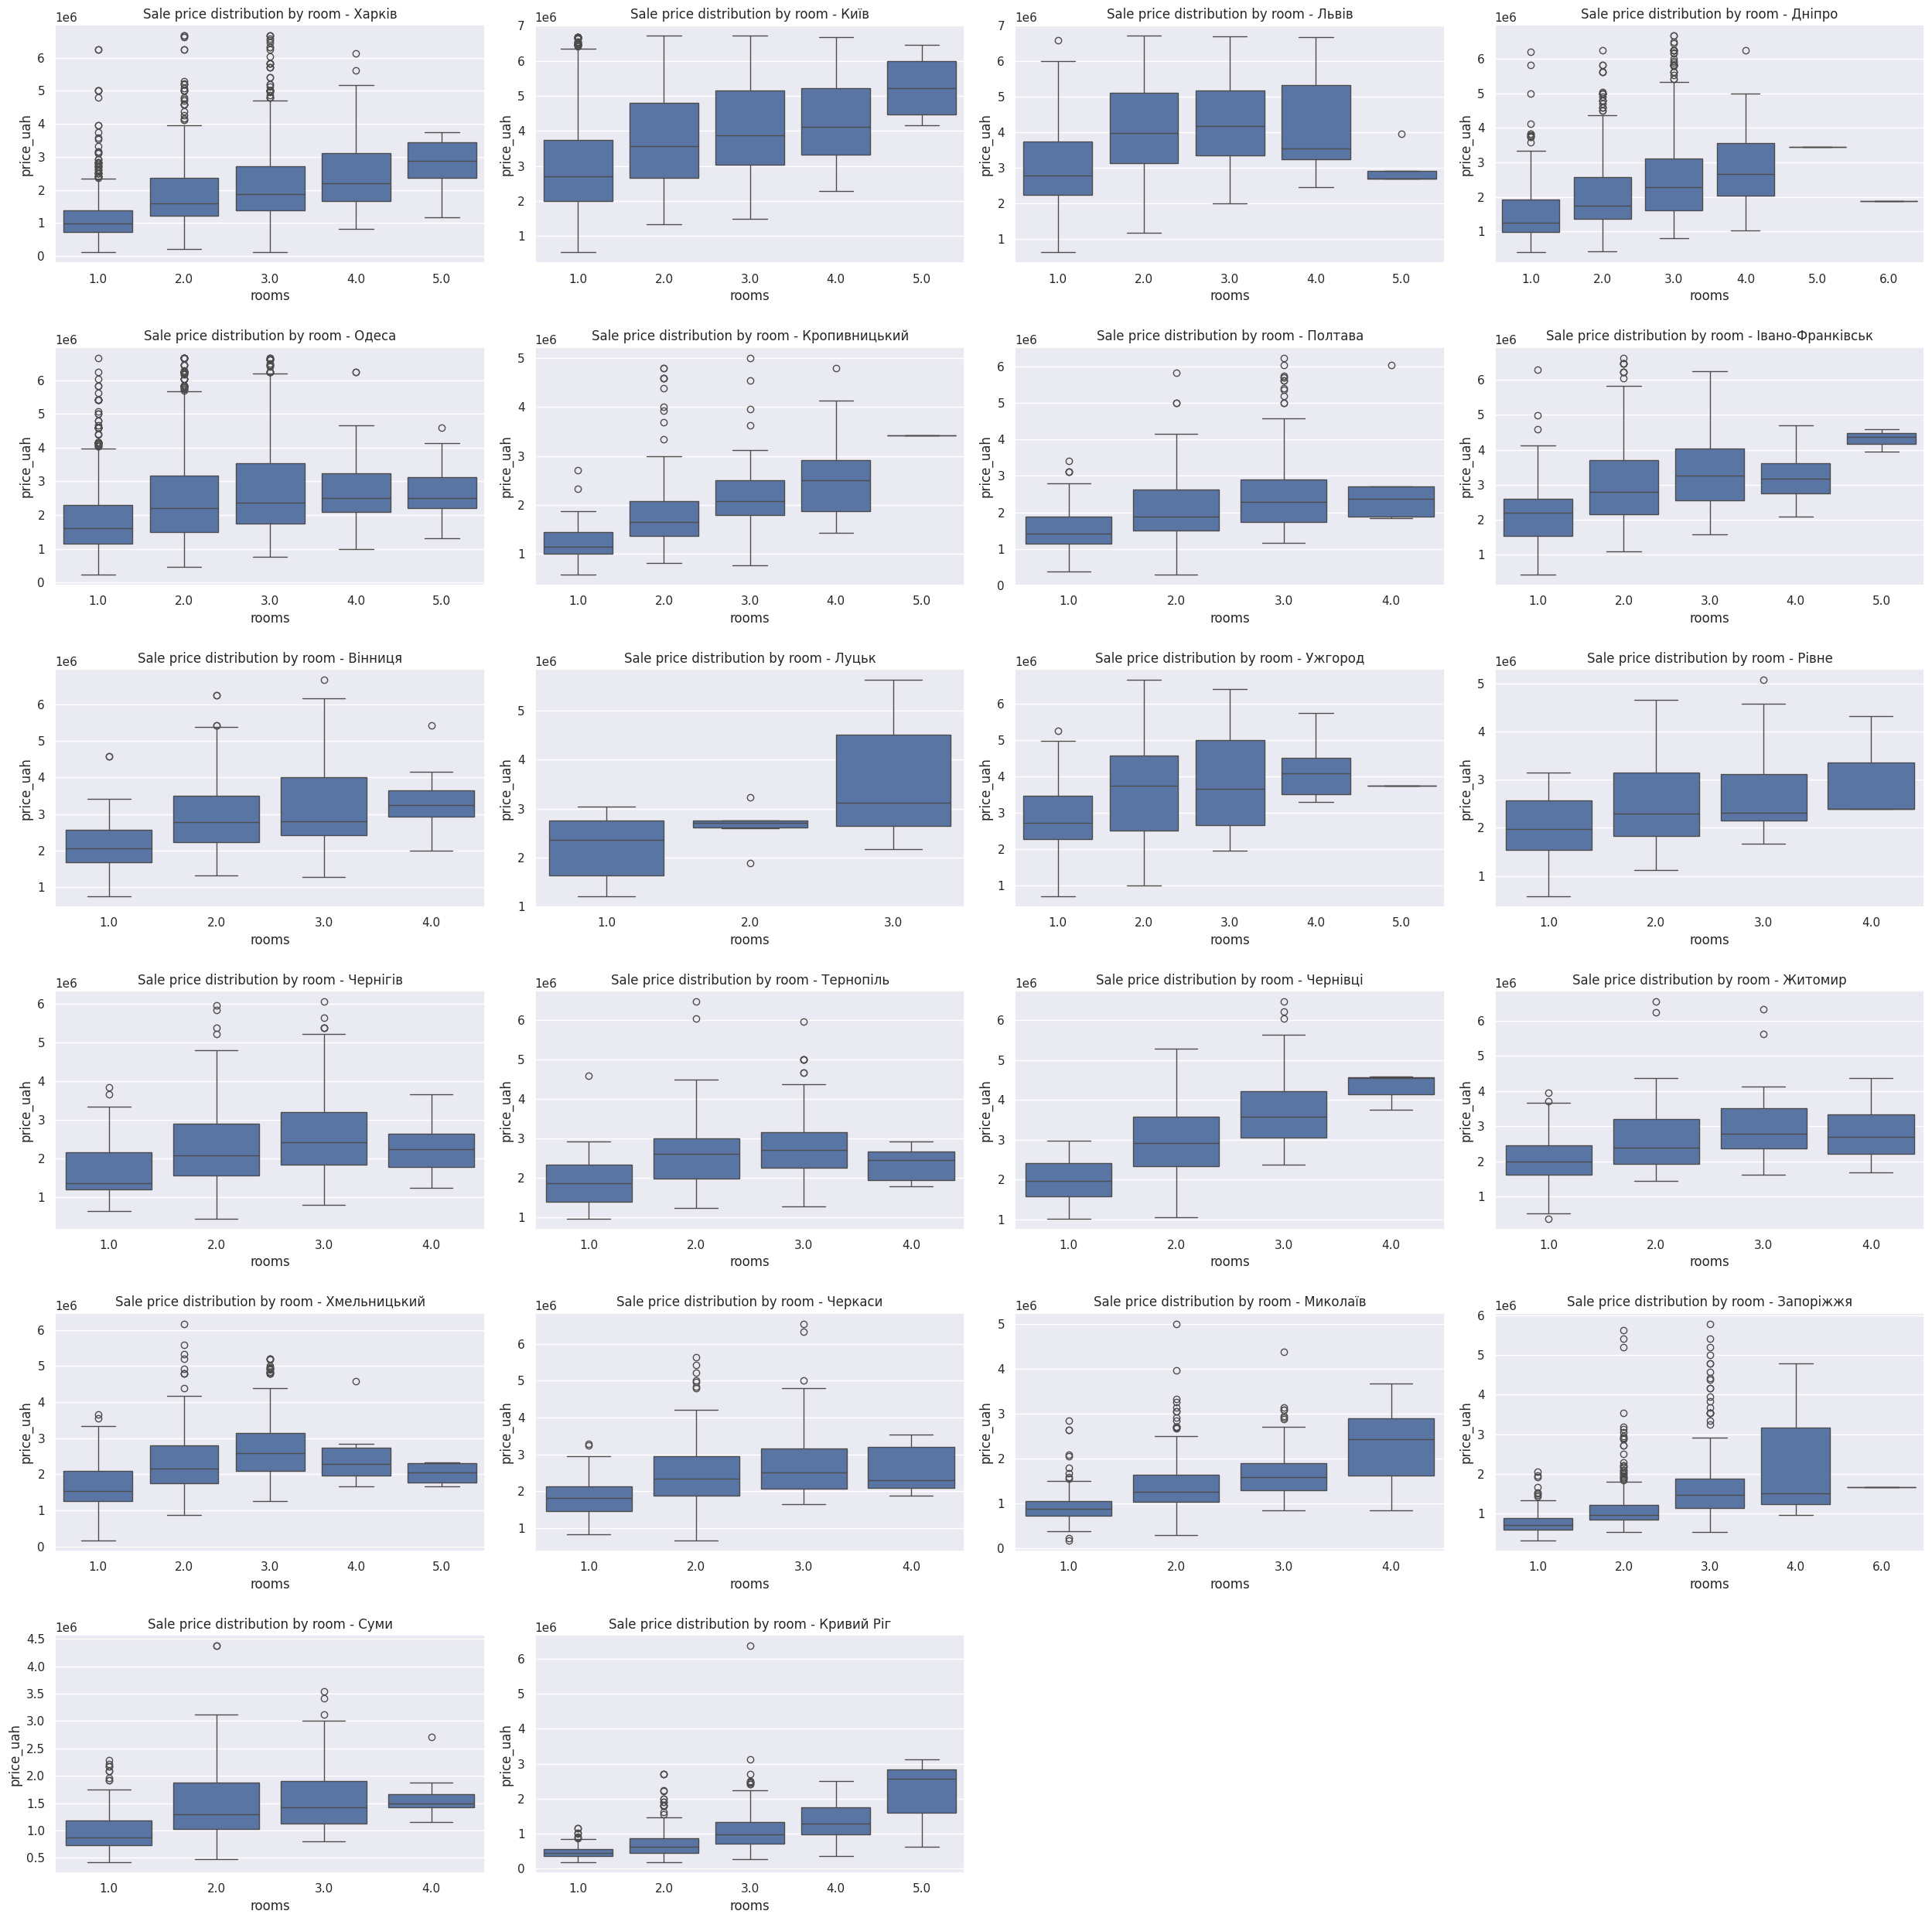

In [39]:
f, axes = plt.subplots(6, 4, figsize=(25, 25))
axes = axes.flatten()

plot_idx = 0
for city in cities:
    temp_df = df[(df['city_name'] == city) & (df['deal_type'] == 'Sale')]
    sns.boxplot(data=temp_df, x='rooms', y='price_uah', ax=axes[plot_idx])
    axes[plot_idx].set_title(f'Sale price distribution by room - {city}')
    plot_idx += 1

for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Also i was wonder what total square have for example one room apartment or two-room and so on...

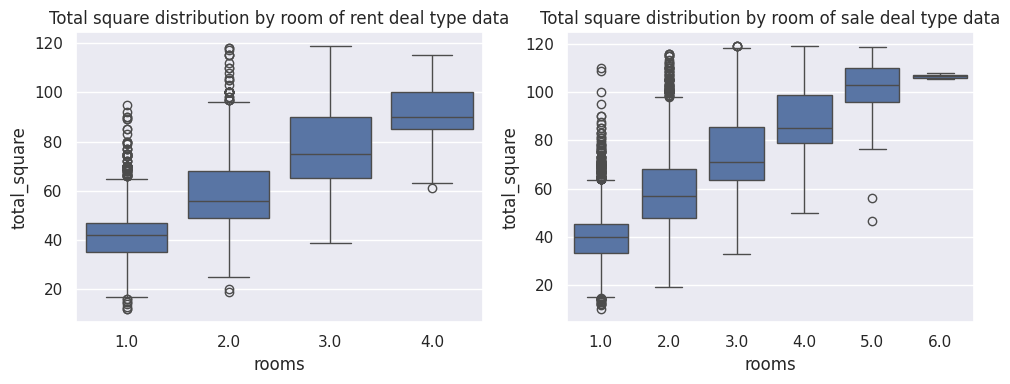

In [40]:
f, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(data=df[df['deal_type']=='Rent'], x='rooms', y='total_square', ax=axes[0])
axes[0].set_title('Total square distribution by room of rent deal type data')

sns.boxplot(data=df[df['deal_type']=='Sale'], x='rooms', y='total_square', ax=axes[1])
axes[1].set_title('Total square distribution by room of sale deal type data')

plt.tight_layout()
plt.show()

We can also check prices based on main area and the number of rooms in a particular city to see which areas have more profitable room layouts for apartments with different deal type.

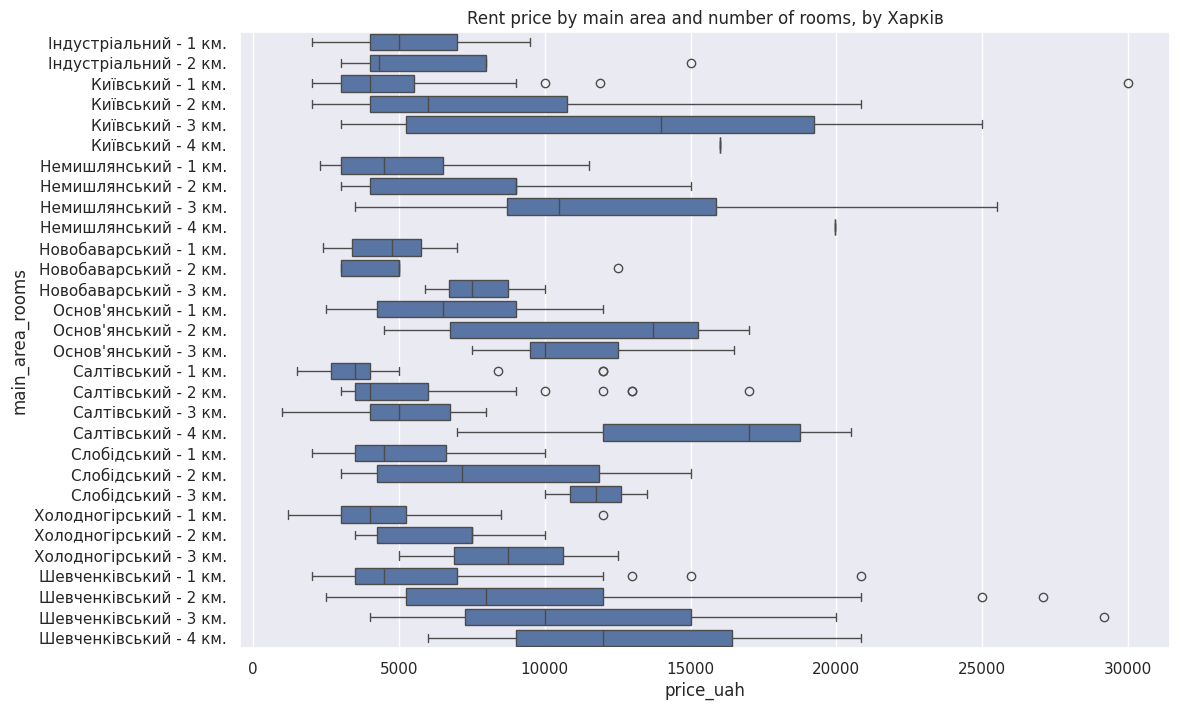

In [41]:
def get_flat_price_by_rooms_main_area(dataframe, deal_type, picked_city):
  temp_df = dataframe[(dataframe['deal_type']==deal_type) & (dataframe['city_name']==picked_city)]
  if temp_df['main_area'].notna().sum() == 0:
    return None
  temp_df['main_area_rooms'] = temp_df['main_area'] + ' - ' + temp_df['rooms'].astype('int32').astype('str') + ' км.'
  temp_df = temp_df.sort_values(by='main_area_rooms')

  plt.figure(figsize=(12, 8))
  sns.boxplot(data=temp_df, x='price_uah', y='main_area_rooms')
  plt.title(f'{deal_type} price by main area and number of rooms, by {picked_city}')
  plt.show()

get_flat_price_by_rooms_main_area(df, 'Rent', 'Харків')

For example in Kharkiv, it's interesting to note that some three-room flats for rent in the Saltivka area are priced even lower than certain one-room flats in other parts of the city.

## Other insights

Also, I want to see which cities have tall buildings and how tall they are.

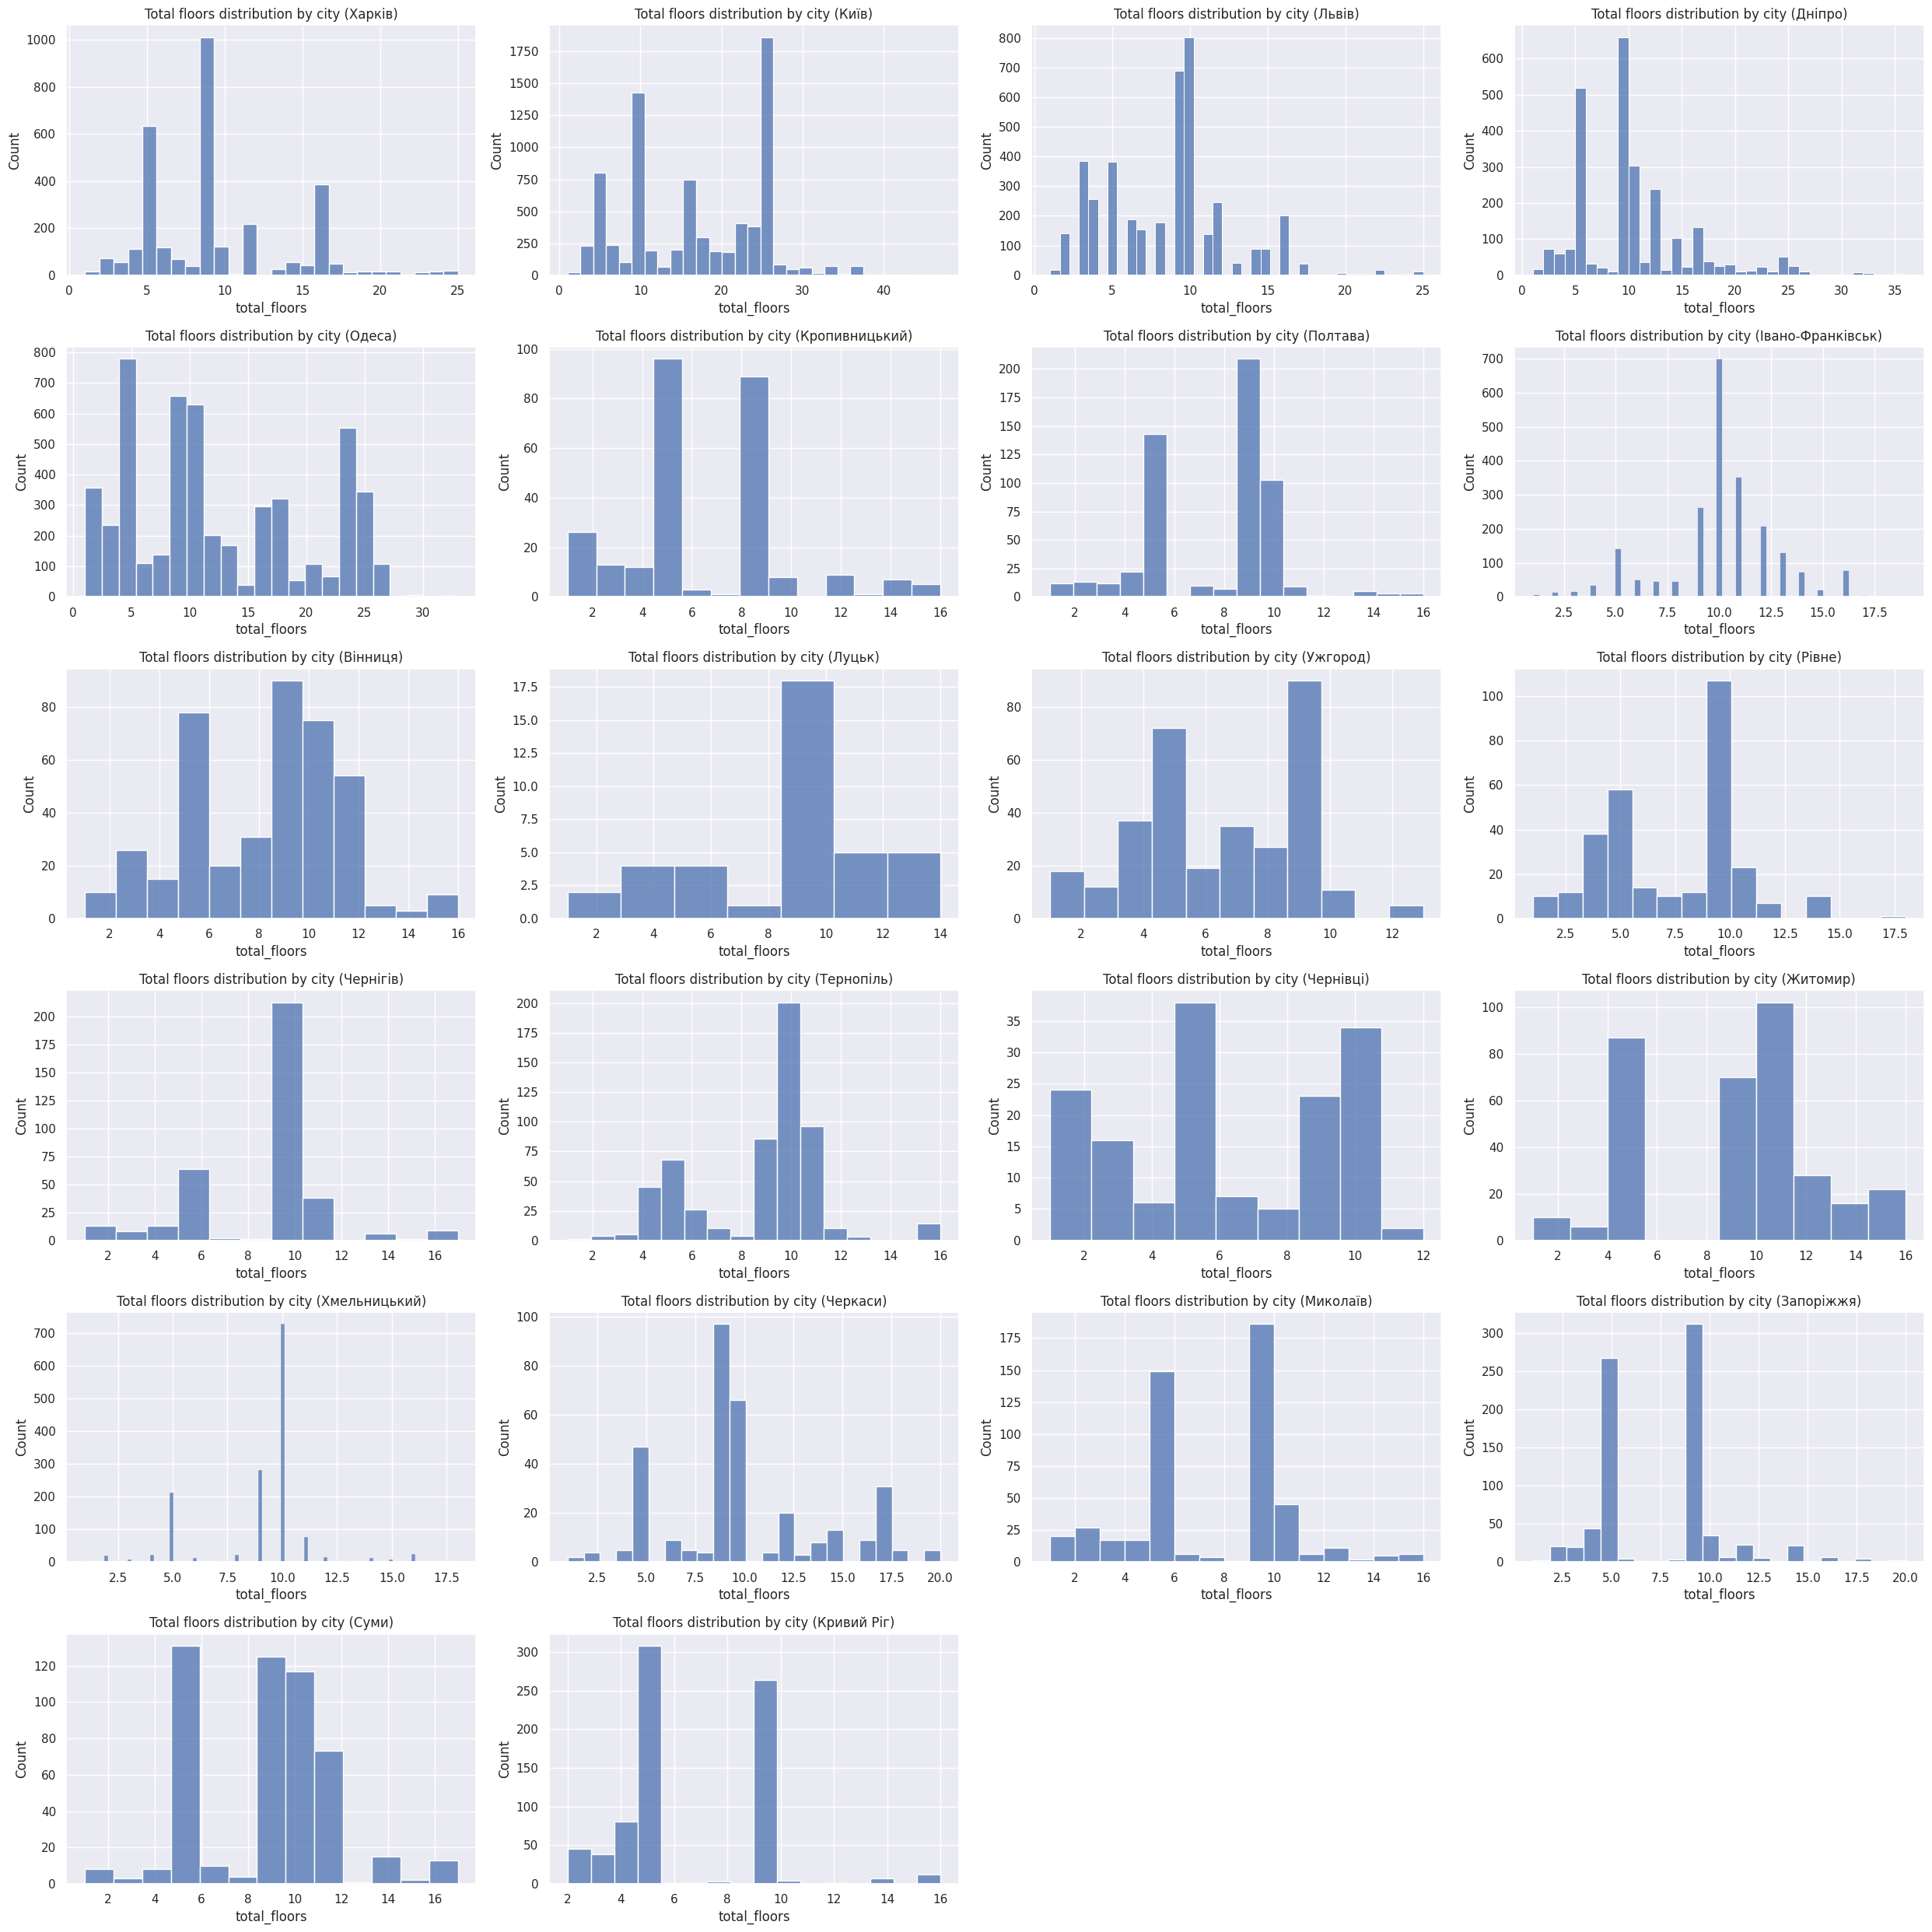

In [42]:
f, axes = plt.subplots(6, 4, figsize=(25, 25))
axes = axes.flatten()

plot_idx = 0
for city in cities:
    temp_df = df[df['city_name'] == city]
    sns.histplot(data=temp_df, x='total_floors', ax=axes[plot_idx])
    axes[plot_idx].set_title(f'Total floors distribution by city ({city})')
    plot_idx += 1

for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

We see that Dnipro and Kyiv have tall tower buildings, while Uzhorod and Chernivtsi do not have particularly high tower buildings, which might suggest that these latter cities prioritize preserving older historical architecture. Next let's see top 10 agencies by each city and new building names.

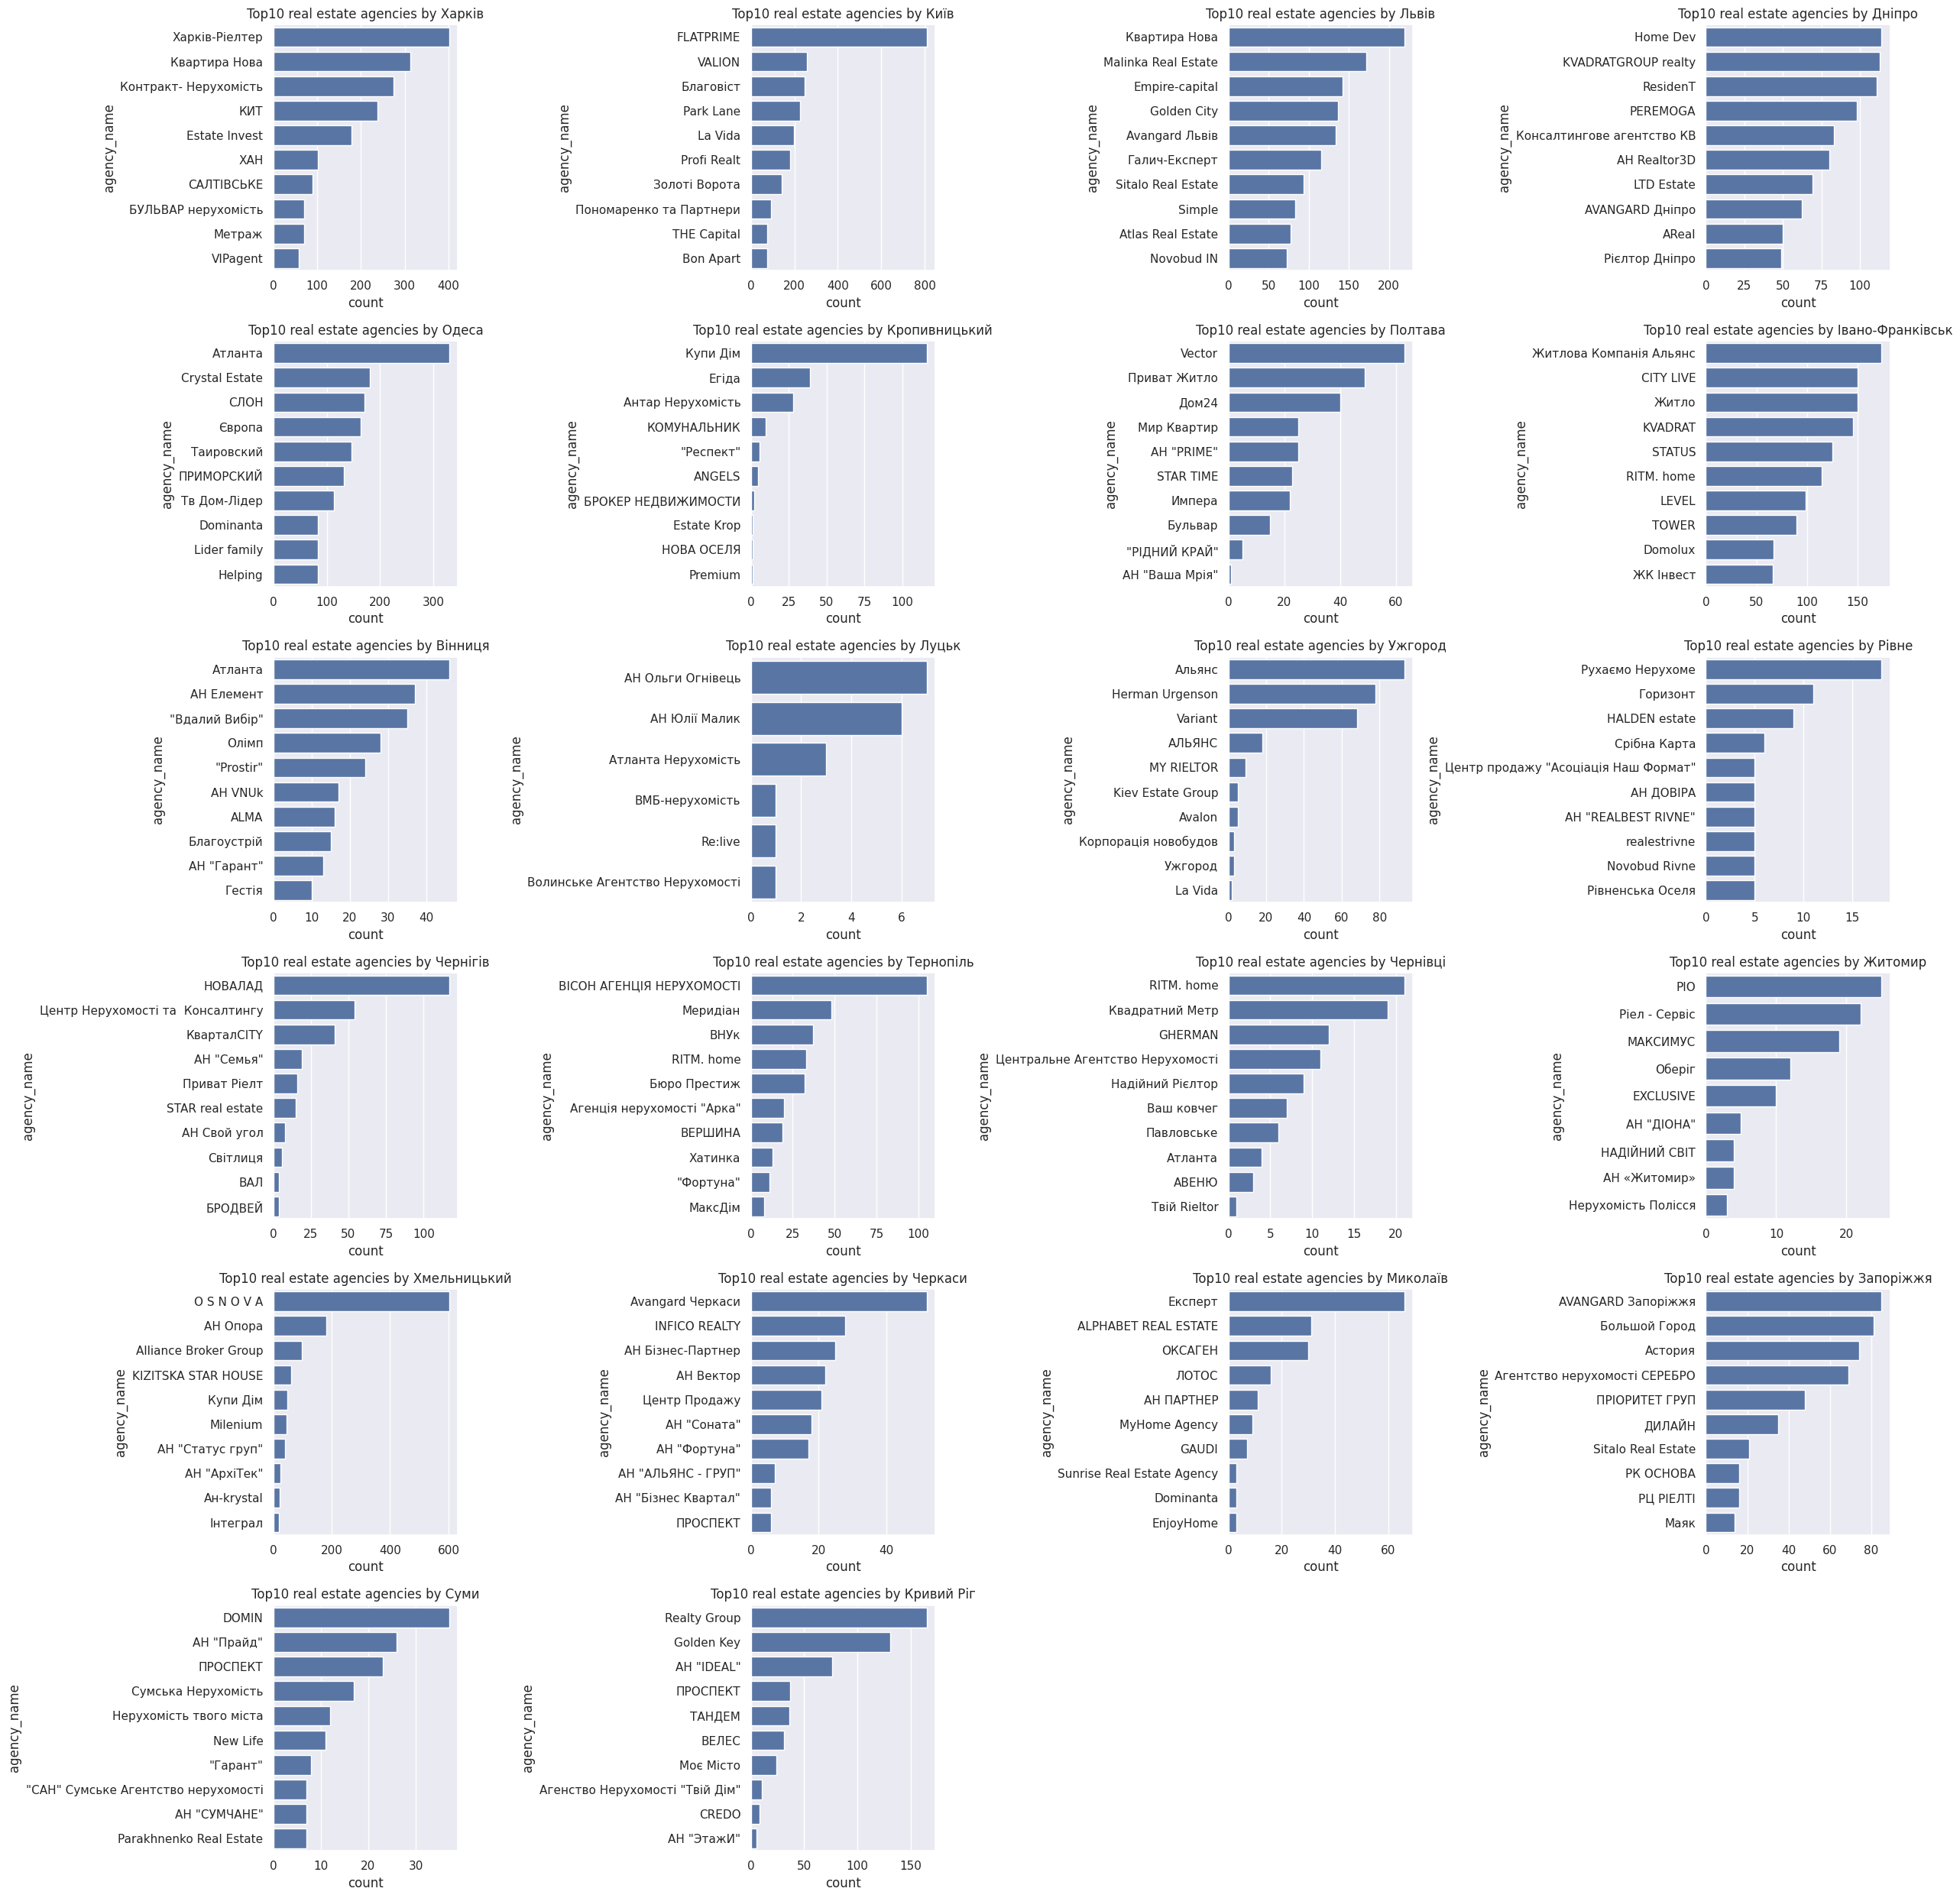

In [43]:
f, axes = plt.subplots(6, 4, figsize=(25, 25))
axes = axes.flatten()

plot_idx = 0
for city in cities:
    temp_df = df[df['city_name'] == city]
    temp_df = temp_df['agency_name'].value_counts().reset_index().head(10)
    temp_df['agency_name'] = temp_df['agency_name'].apply(lambda x: x.split(' ')[-1] if len(x) > 40 else x)
    sns.barplot(data=temp_df, x='count', y='agency_name', ax=axes[plot_idx])
    axes[plot_idx].set_title(f'Top10 real estate agencies by {city}')
    plot_idx += 1

for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

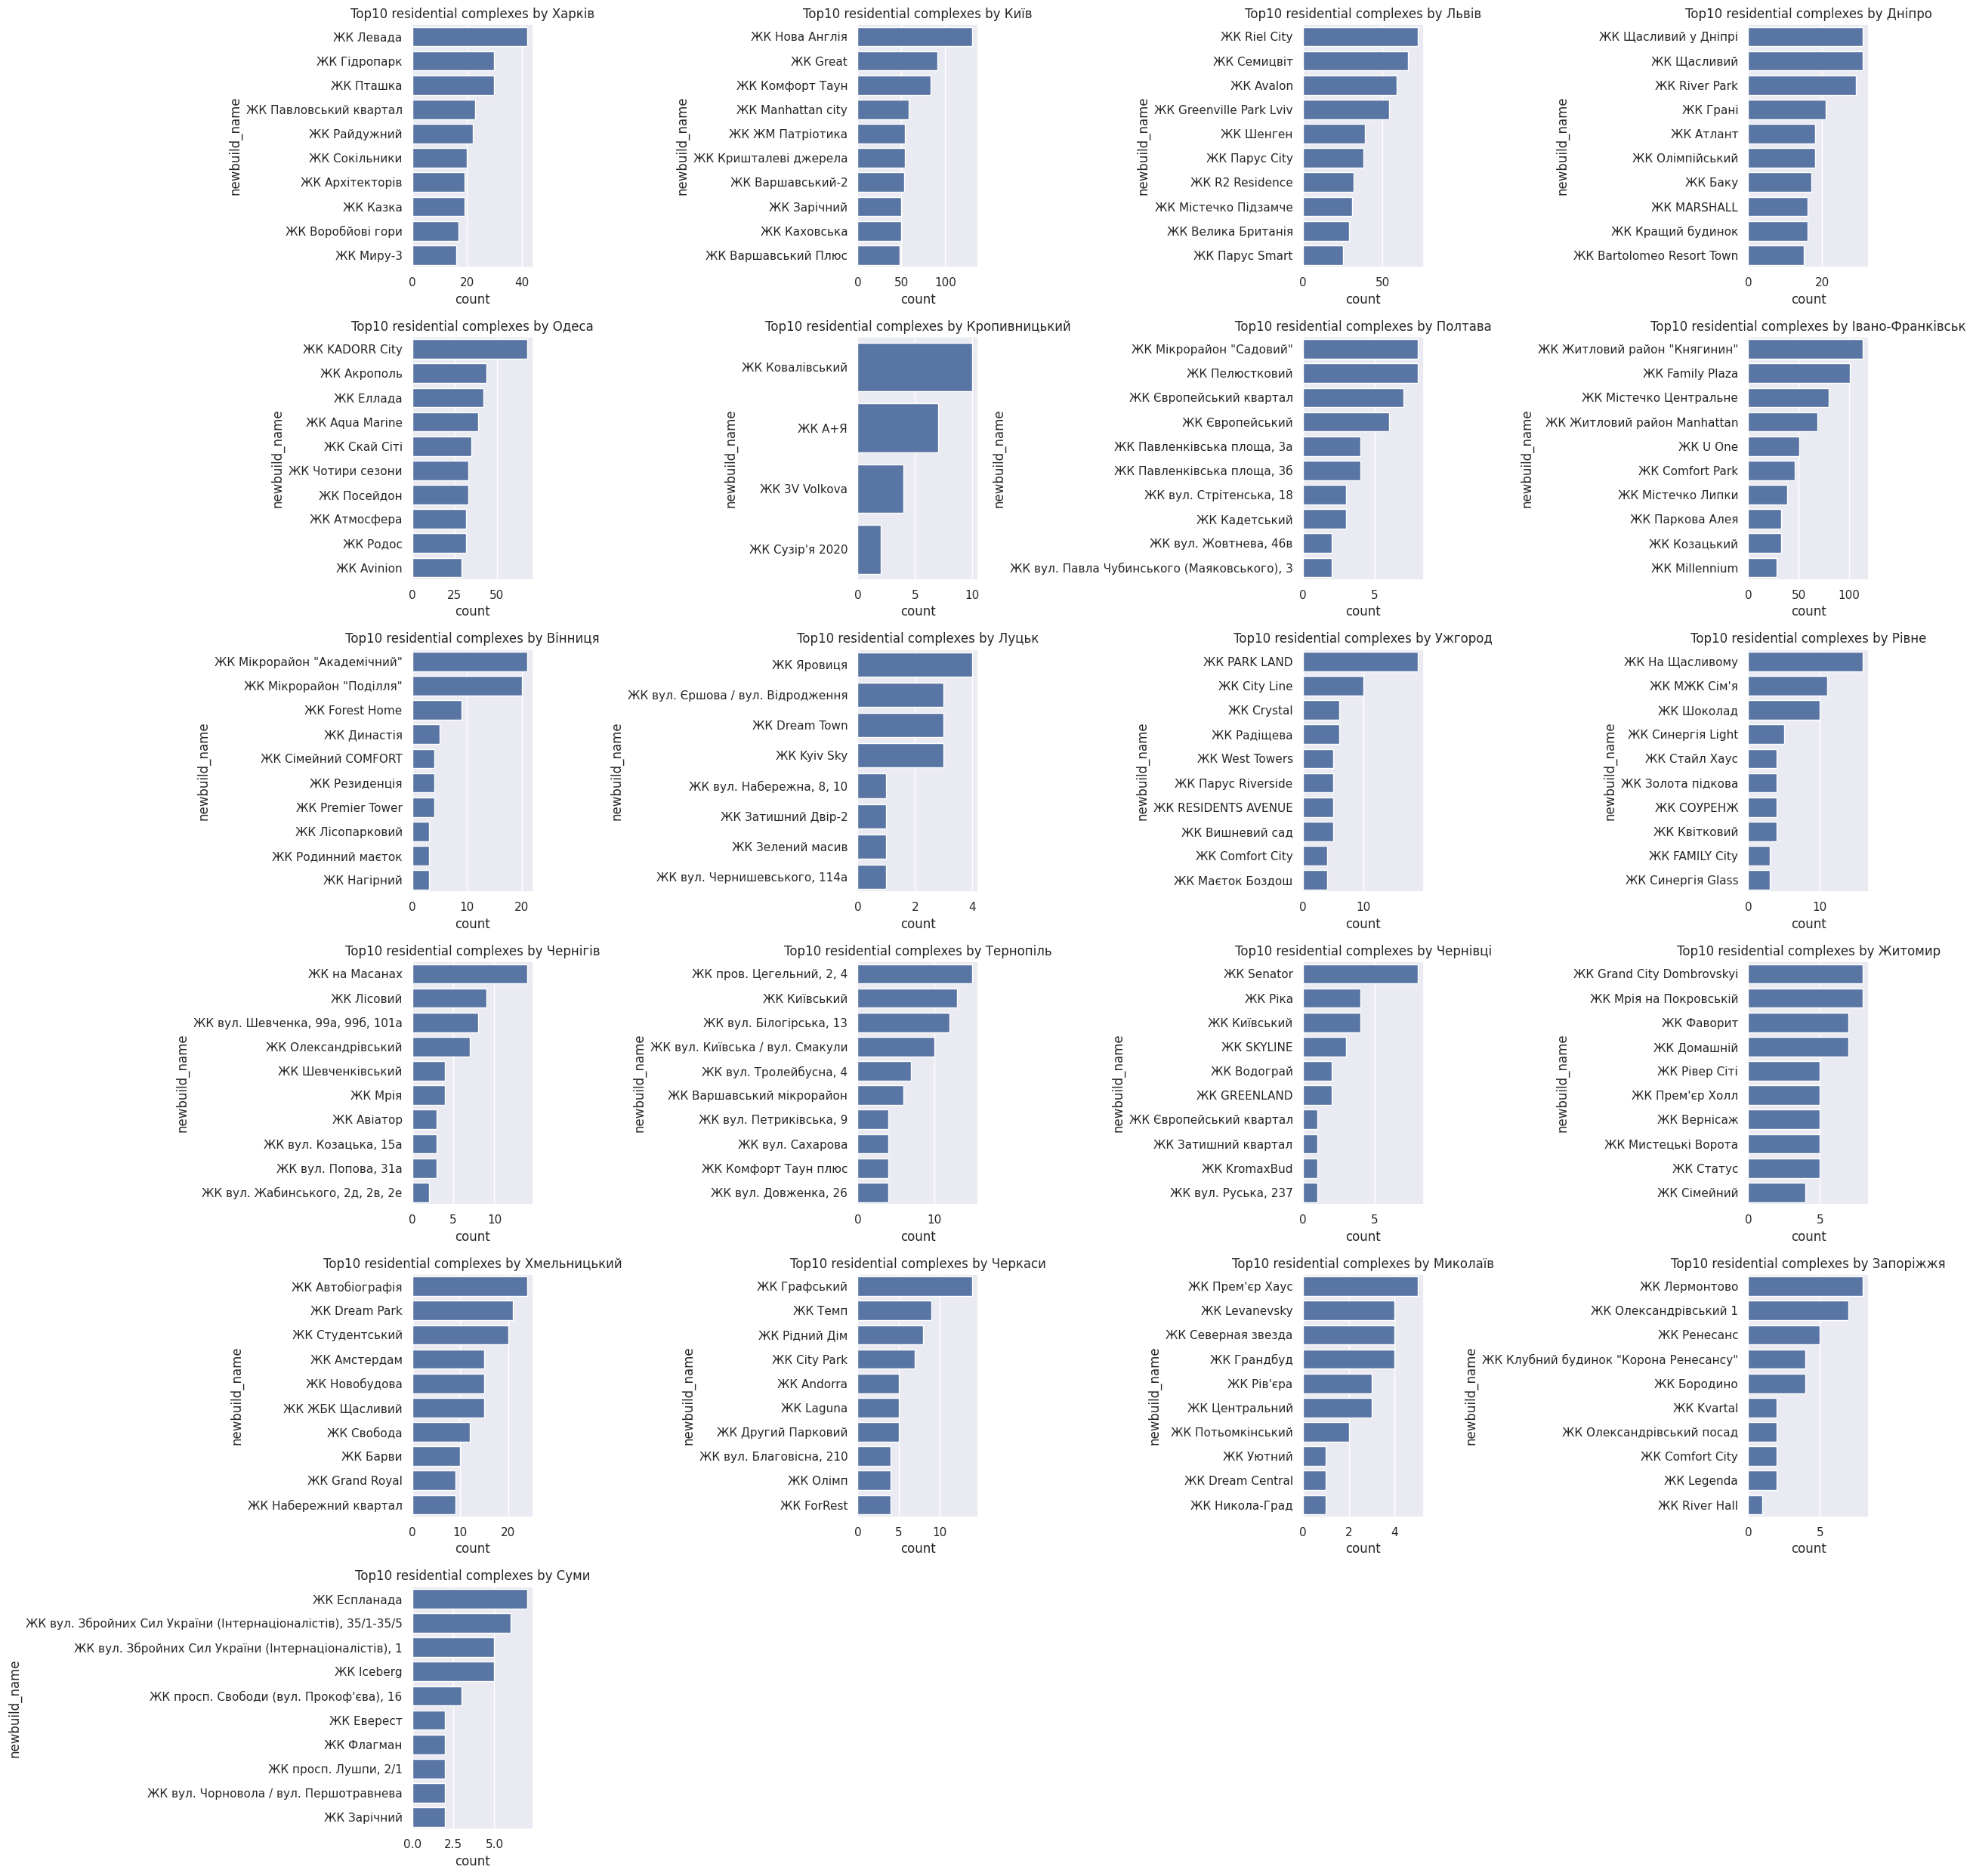

In [44]:
f, axes = plt.subplots(6, 4, figsize=(25, 25))
axes = axes.flatten()

plot_idx = 0
for city in cities:
    temp_df = df[df['city_name'] == city]
    if temp_df['newbuild_name'].notna().sum() == 0:
      continue
    temp_df = temp_df['newbuild_name'].value_counts().reset_index().head(10)
    # temp_df['newbuild_name'] = temp_df['newbuild_name'].apply(lambda x: x.split(' ')[-1] if len(x) > 40 else x)
    sns.barplot(data=temp_df, x='count', y='newbuild_name', ax=axes[plot_idx])
    axes[plot_idx].set_title(f'Top10 residential complexes by {city}')
    plot_idx += 1

for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

And finally let's see correlation matrix of all numeric data for rent and sale deal type.

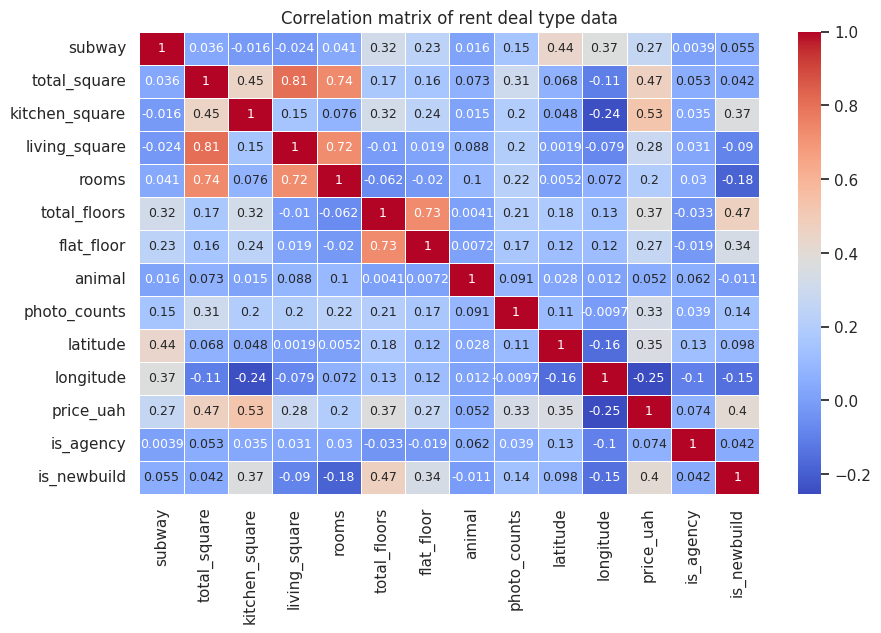

In [45]:
numeric_columns_rent = df.select_dtypes(include='number').columns
numeric_columns_rent = [item for item in numeric_columns_rent if item not in ('checked_apartment')]
corr_matrix_rent = df[df['deal_type']=='Rent'][numeric_columns_rent].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_rent, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 9})
plt.title('Correlation matrix of rent deal type data')
plt.show()

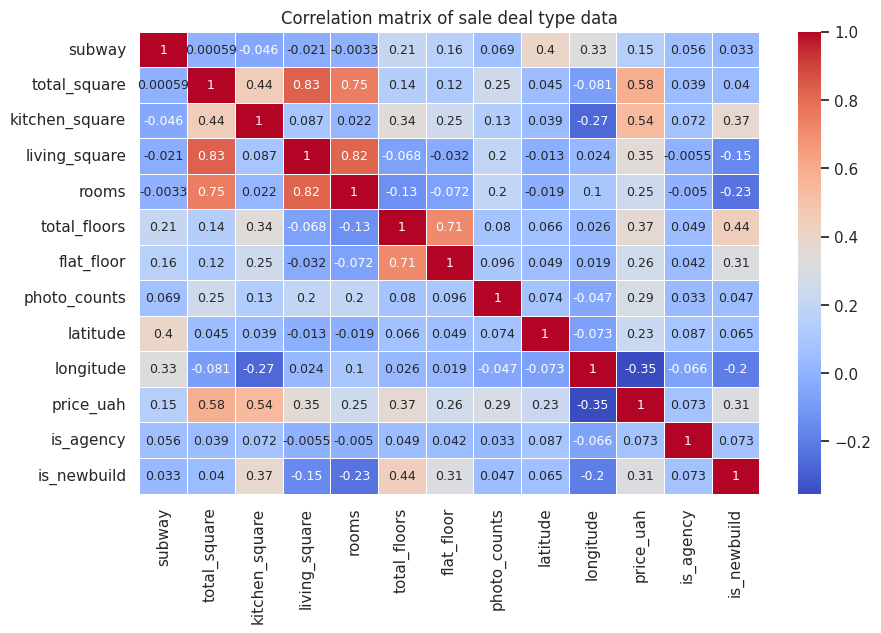

In [46]:
numeric_columns_sale = df.select_dtypes(include='number').columns
numeric_columns_sale = [item for item in numeric_columns_sale if item not in ('checked_apartment', 'animal')]
corr_matrix_sale = df[df['deal_type']=='Sale'][numeric_columns_sale].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_sale, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 9})
plt.title('Correlation matrix of sale deal type data')
plt.show()

From this correlation matrix, we can observe that sale data exhibits a more pronounced linear relationship with fundamental parameters like total square footage and kitchen square footage, and is better explained by these factors compared to rental data. So, for further machine learning modeling, I will use the sale deal type data.

# NLP research from description

## Dependencies for next text research

In [47]:
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import string

In [48]:
nltk.download('stopwords')
stopwords_ru = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Simple text preprocessing

In [50]:
with open('/content/punctuation.txt', 'r', encoding='utf-8') as file:
  punctuation = set(file.read().split('\n'))
punctuation = ''.join(punctuation)

with open('/content/stopwords_ua.txt', 'r', encoding='utf-8') as file:
  stopwords_ua = set(file.read().split('\n'))

In [51]:
def drop_punctuation_with_spaces(text: str, file_punctuation=punctuation):
    str_punct = string.punctuation + file_punctuation
    cleaned = ''.join(' ' if element in str_punct else element for element in text)
    return ' '.join(cleaned.split())

def drop_numbers(text: str):
  return re.sub(r'\d+', "", text)

def other_preprocessing(text: str):
  text = re.sub(r'\s+', ' ', text)
  text = text.lower()
  return text.strip()

In [52]:
temptemp_df = df.copy()
temptemp_df = temptemp_df.dropna(subset='description')

temptemp_df['description'] = temptemp_df['description'].apply(lambda text: drop_punctuation_with_spaces(text))
temptemp_df["description"] = temptemp_df['description'].apply(lambda text: drop_numbers(text))
temptemp_df["description"] = temptemp_df['description'].apply(lambda text: other_preprocessing(text))

In [53]:
stopwords_ua.update(stopwords_ru)
stopwords_ua.update(STOPWORDS)

In [54]:
sale_text = " ".join(review for review in temptemp_df[temptemp_df['deal_type']=='Sale']['description'] if review is not None and type(review) == str)
rent_text = " ".join(review for review in temptemp_df[temptemp_df['deal_type']=='Rent']['description'] if review is not None and type(review) == str)

## Top words in the description

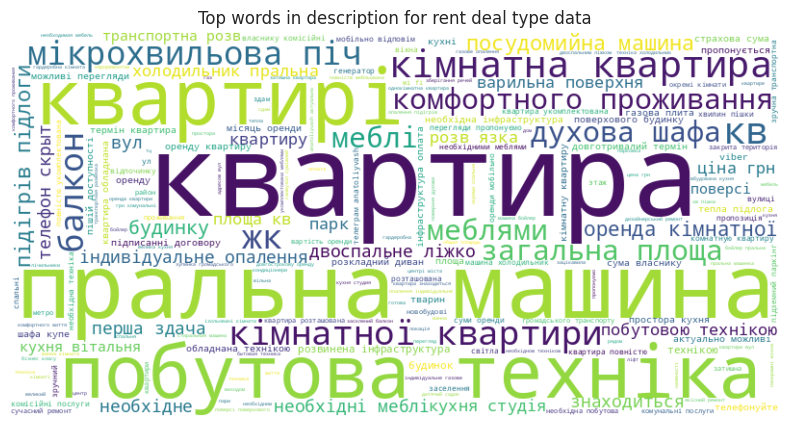

In [55]:
wordcloud = WordCloud(width=800, height=400, stopwords=stopwords_ua, background_color='white').generate(rent_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top words in description for rent deal type data')
plt.axis('off')
plt.show()

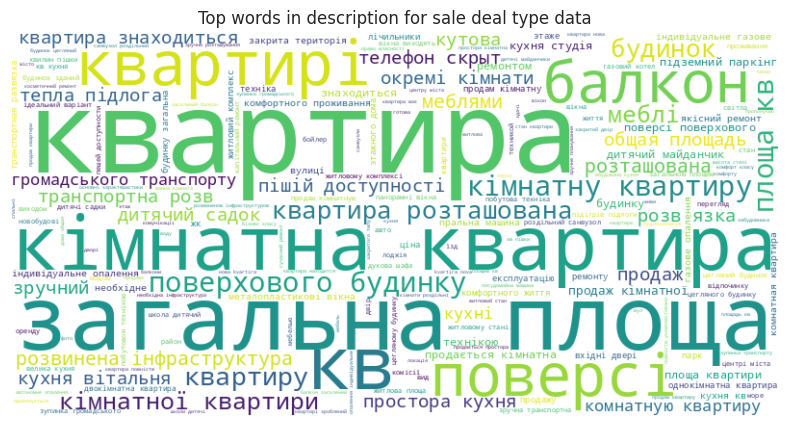

In [56]:
wordcloud = WordCloud(width=800, height=400, stopwords=stopwords_ua, background_color='white').generate(sale_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top words in description for sale deal type data')
plt.axis('off')
plt.show()

We observe a significant difference in the descriptions between different deal types. For example, descriptions for rental flats frequently mention household appliances, whereas descriptions for flats for sale more often emphasize location.

In [57]:
# for the next machine learning model, we definitely don't need these columns
df.drop(columns=['agency_name', 'is_agency', 'checked_apartment', 'description'], inplace=True)

In [58]:
df.to_csv('lun_real_estate_data.csv', index=False)

DONE